In [1]:
import joblib
from joblib import delayed, Parallel
import numpy as np
import pandas as pd
from predict_snar.smiles import ReactionSmilesProcessor, AgentDetector
from rdkit import Chem
from rdkit.Chem import AllChem
from IPython.display import SVG
import matplotlib.pyplot as plt
import seaborn as sns

fcntl not avaiable on Windows.
resource not available on Windows.


In [2]:
%matplotlib inline

# Read and process raw reactions with the ReactionSmilesProcessor

In [3]:
rsmps = np.array(joblib.load("rsmps.joblib"))

In [4]:
#df = pd.read_csv("pruned_validation.csv", header=None, names=["reaction_smiles"])
#rsmps = []
#failed = []
#subset = len(df)
#for i, reaction_smiles in enumerate(df["reaction_smiles"][:subset]):
#    try:
#        reaction = AllChem.ReactionFromSmarts(reaction_smiles, useSmiles=True)
#        AllChem.RemoveMappingNumbersFromReactions(reaction)
#        reaction_smiles = AllChem.ReactionToSmiles(reaction)
#        rsmp = ReactionSmilesProcessor(reaction_smiles)
#        rsmps.append(rsmp)
#    except Exception as e:
#        print("...Failed:", i + 1)
#        failed.append(reaction_smiles)
#    if (i + 1) % 100 == 0:
#        print("Finished", i + 1)

In [5]:
#joblib.dump(rsmps, "rsmps.joblib")

Retain bimolecular reactions

In [6]:
mask = np.array([1 if rsmp.nu else 0 for rsmp in rsmps], dtype=bool)

In [7]:
iso_df = pd.DataFrame(rsmps[mask], columns=["rsmp"], index=np.where(mask)[0])   

# Curation

Display boronic acids

In [8]:
pattern = Chem.MolFromSmarts("[B]")
for i, rsmp in iso_df["rsmp"].iteritems():
    mol = rsmp.substrate
    if mol.HasSubstructMatch(pattern):
        print(i)
        display(mol)

Display phosphines

In [9]:
pattern = Chem.MolFromSmarts("[P;v3]")
for i, rsmp in iso_df["rsmp"].iteritems():
    for agent in rsmp.agents:
        if agent.HasSubstructMatch(pattern):
            print(i)
            display(agent)

## Adjust nucleophile and leaving group protonation state

In [10]:
nu_negative = ["O", "S"]

In [11]:
for row_index, rsmp in iso_df["rsmp"].iteritems():   
    nu_atom = rsmp.nu.GetAtomWithIdx(rsmp.nu_atom[0])
    nu_charge = nu_atom.GetFormalCharge()
    nu_symbol = nu_atom.GetSymbol()
    
    # Check for deprotonation of amines
    ad = AgentDetector()
    for agent in rsmp.agents:
        ad.process_mol(agent)
    
    if (np.any(np.array(ad.pkas["strong_bases"]) > 15) or any([name in ad.names["weak_bases"] for name in ("Carbonate", "Phosphate", "Amidine", "Guanidine", "Proton sponge")])) and nu_symbol == "N":
        amide = True
    else:
        amide = False  
   
    # Adjust faulty charges of protonated amines
    if nu_charge == 1:
        nu_atom.SetFormalCharge(nu_charge - 1)
        nu_atom.SetNumExplicitHs(nu_atom.GetTotalNumHs() - 1)
        nu_atom.UpdatePropertyCache()
    # Adjust charges of S and O
    elif nu_charge == 0 and nu_symbol in nu_negative:
        nu_atom.SetFormalCharge(nu_charge - 1)
        if nu_atom.GetNumExplicitHs() > 0:
            nu_atom.SetNumExplicitHs(nu_atom.GetNumExplicitHs() - 1)
            nu_atom.UpdatePropertyCache()
        lg_atom = rsmp.lgs[0].GetAtomWithIdx(rsmp.lg_atom_orig[0])
        lg_charge = lg_atom.GetFormalCharge()
        lg_atom.SetFormalCharge(lg_charge - 1)
        if lg_atom.GetNumExplicitHs() > 0:
            lg_atom.SetNumExplicitHs(lg_atom.GetNumExplicitHs() - 1)
            lg_atom.UpdatePropertyCache()
    # Adjust protonation state of NH in rings
    elif amide:
        n_h_nu = nu_atom.GetTotalNumHs()
        rings = ReactionSmilesProcessor._get_aromatic_rings(rsmp.nu, merge=False)
        reactive_rings = [ring for ring in rings if rsmp.nu_atom[0] in ring]
        ring_ns = []
        if len(reactive_rings) > 0:
            for i in reactive_rings[0]:
                atom = rsmp.nu.GetAtomWithIdx(i)
                if atom != nu_atom and atom.GetSymbol() == "N" and atom.GetTotalNumHs() > 0:
                    ring_ns.append(atom)
        if n_h_nu > 0 and nu_atom.GetIsAromatic():
            nu_atom.SetFormalCharge(nu_charge - 1)
            if nu_atom.GetNumExplicitHs() > 0:
                nu_atom.SetNumExplicitHs(nu_atom.GetNumExplicitHs() - 1)
                nu_atom.UpdatePropertyCache()
            lg_atom = rsmp.lgs[0].GetAtomWithIdx(rsmp.lg_atom_orig[0])
            lg_charge = lg_atom.GetFormalCharge()
            lg_atom.SetFormalCharge(lg_charge - 1)
            if lg_atom.GetNumExplicitHs() > 0:
                lg_atom.SetNumExplicitHs(lg_atom.GetNumExplicitHs() - 1)
                lg_atom.UpdatePropertyCache()            
        elif len(ring_ns) > 0 and nu_atom.GetIsAromatic():
            n_ring_atom = ring_ns[0]
            #n_ring_atom.SetFormalCharge(n_ring_atom.GetFormalCharge() - 1)
            nu_atom.SetFormalCharge(nu_atom.GetFormalCharge() - 1)
            n_ring_atom.SetNumExplicitHs(n_ring_atom.GetNumExplicitHs() - 1)
            n_ring_atom.UpdatePropertyCache()
            lg_atom = rsmp.lgs[0].GetAtomWithIdx(rsmp.lg_atom_orig[0])
            lg_charge = lg_atom.GetFormalCharge()
            lg_atom.SetFormalCharge(lg_charge - 1)
            if lg_atom.GetNumExplicitHs() > 0:
                lg_atom.SetNumExplicitHs(lg_atom.GetNumExplicitHs() - 1)
                lg_atom.UpdatePropertyCache()
    elif nu_atom.GetIsAromatic() and nu_atom.GetTotalNumHs() > 0:
        nu_atom.SetFormalCharge(nu_charge - 1)
        if nu_atom.GetNumExplicitHs() > 0:
            nu_atom.SetNumExplicitHs(nu_atom.GetNumExplicitHs() - 1)
            nu_atom.UpdatePropertyCache()
        lg_atom = rsmp.lgs[0].GetAtomWithIdx(rsmp.lg_atom_orig[0])
        lg_charge = lg_atom.GetFormalCharge()
        lg_atom.SetFormalCharge(lg_charge - 1)
        if lg_atom.GetNumExplicitHs() > 0:
            lg_atom.SetNumExplicitHs(lg_atom.GetNumExplicitHs() - 1)
            lg_atom.UpdatePropertyCache()     

    rsmp._create_reaction()

In [12]:
iso_df["reaction_smiles"] = iso_df["rsmp"].apply(lambda x: x.reaction_smiles)
iso_df["substrate_smiles"] = iso_df["rsmp"].apply(lambda x: Chem.MolToSmiles(x.substrate))
iso_df["nu_smiles"] = iso_df["rsmp"].apply(lambda x: Chem.MolToSmiles(x.nu))
iso_df["product_smiles"] = iso_df["rsmp"].apply(lambda x: Chem.MolToSmiles(x.products[0]))
iso_df["chemical_formula"] = iso_df["rsmp"].apply(lambda x: AllChem.CalcMolFormula(x.products[0]))
iso_df["product_mw"] = iso_df["rsmp"].apply(lambda x: Chem.Descriptors.MolWt(x.products[0]))   

## Remove pure duplicates

In [13]:
n_before = len(iso_df)
iso_df.drop_duplicates("reaction_smiles", inplace=True)
n_after = len(iso_df)
print("Reactions removed:", n_before - n_after)

Reactions removed: 7


## Construct reaction smiles without any agent

In [14]:
reactions_smiles_no_agent = []
for rsmp in iso_df["rsmp"]:
    reaction = AllChem.ChemicalReaction(rsmp.reaction)
    reaction.RemoveAgentTemplates()
    reaction_smiles = AllChem.ReactionToSmiles(reaction)
    reactions_smiles_no_agent.append(reaction_smiles)
iso_df["reaction_smiles_no_agent"] = reactions_smiles_no_agent  

## Remove duplicates

In [15]:
n_before = len(iso_df)
iso_df.drop_duplicates(["reaction_smiles_no_agent"], inplace=True)
n_after = len(iso_df)
print("Reactions removed:", n_before - n_after)

Reactions removed: 31


## Check against modelling dataset

In [17]:
df = pd.read_csv("../machine_learning/train_test_data/processed_data.csv", index_col=0)

In [18]:
n_overlap = df["reaction_smiles"].isin(iso_df["reaction_smiles_no_agent"]).sum()
print("Overlapping reactions:", n_overlap)

Overlapping reactions: 0


# Check for isomeric product formation

In [19]:
gb = iso_df[iso_df.duplicated(["chemical_formula", "substrate_smiles", "nu_smiles"], keep=False)].groupby(["substrate_smiles", "nu_smiles"])
groups = [list(indices) for indices in gb.groups.values()]

[1041, 1517]


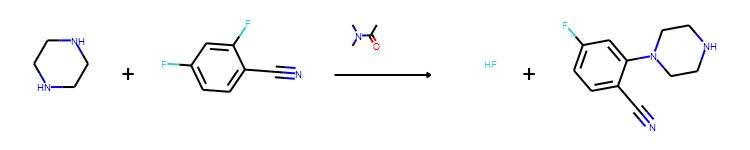

[1041, 1517]


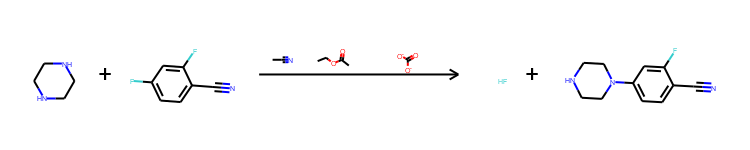

In [20]:
for i, group in enumerate(groups, start=1):
    duplicates = iso_df.loc[group]["reaction_smiles"]
    for reaction_smiles in duplicates:
        print(group)
        display(AllChem.ReactionFromSmarts(reaction_smiles, useSmiles=True))        

Sadly, only one reaction with regioisomers. Remvoving second examples for now

In [21]:
iso_df.drop_duplicates(["chemical_formula", "substrate_smiles", "nu_smiles"], inplace=True)

# Check distribution of nucleophiles and leaving groups

In [22]:
iso_df["nu_symbol"] = iso_df["rsmp"].apply(lambda x: x.nu.GetAtomWithIdx(x.nu_atom[0]).GetSymbol())
iso_df["lg_symbol"] = iso_df["rsmp"].apply(lambda x: x.substrate.GetAtomWithIdx(x.lg_atom[0]).GetSymbol())

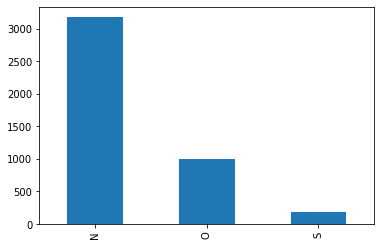

In [23]:
iso_df["nu_symbol"].value_counts().plot.bar()

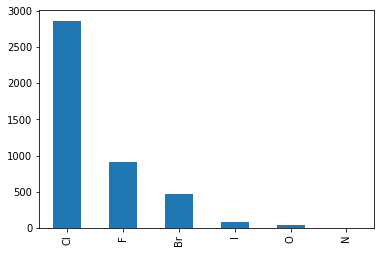

In [24]:
iso_df["lg_symbol"].value_counts().plot.bar()

Investigate N leaving group. Interpretation is that N is substituted over halogen. Not possible to correct without hard rules or ranking of leaving group strength.

In [27]:
iso_df[iso_df["lg_symbol"] == "N"]

,rsmp,reaction_smiles,substrate_smiles,nu_smiles,product_smiles,chemical_formula,product_mw,reaction_smiles_no_agent,nu_symbol,lg_symbol
2366,<predict_snar.smiles.ReactionSmilesProcessor o...,COCC1CCCCN1c1ncnc(Nc2cccc(CS(N)(=O)=O)c2)n1.NC...,COCC1CCCCN1c1ncnc(Nc2cccc(CS(N)(=O)=O)c2)n1,NC(=O)C1CCCN1,NC(=O)C1CCCN1c1ncnc(Nc2cccc(CS(N)(=O)=O)c2)n1,C15H19N7O3S,377.430,COCC1CCCCN1c1ncnc(Nc2cccc(CS(N)(=O)=O)c2)n1.NC...,N,N
2385,<predict_snar.smiles.ReactionSmilesProcessor o...,CC(Nc1nc(F)c(F)cc1[N+](=O)[O-])c1ccc(F)cn1.NC(...,CC(Nc1nc(F)c(F)cc1[N+](=O)[O-])c1ccc(F)cn1,NC(CO)c1ccc(F)cn1,O=[N+]([O-])c1cc(F)c(F)nc1NC(CO)c1ccc(F)cn1,C12H9F3N4O3,314.223,CC(Nc1nc(F)c(F)cc1[N+](=O)[O-])c1ccc(F)cn1.NC(...,N,N
3097,<predict_snar.smiles.ReactionSmilesProcessor o...,CC(C)(C)OC(=O)NC1(CN)CCCC1.CC(C)(C)OC(=O)NCCNc...,CC(C)(C)OC(=O)NCCNc1nc(Cl)ncc1Br,CC(C)(C)OC(=O)NC1(CN)CCCC1,CC(C)(C)OC(=O)NC1(CNc2nc(Cl)ncc2Br)CCCC1,C15H22BrClN4O2,405.724,CC(C)(C)OC(=O)NC1(CN)CCCC1.CC(C)(C)OC(=O)NCCNc...,N,N
3150,<predict_snar.smiles.ReactionSmilesProcessor o...,COCC1CCCCN1c1ncnc(Nc2cccc(CS(N)(=O)=O)c2)n1.CO...,COCC1CCCCN1c1ncnc(Nc2cccc(CS(N)(=O)=O)c2)n1,COCC1CCN1,COCC1CCN1c1ncnc(Nc2cccc(CS(N)(=O)=O)c2)n1,C15H20N6O3S,364.431,COCC1CCCCN1c1ncnc(Nc2cccc(CS(N)(=O)=O)c2)n1.CO...,N,N


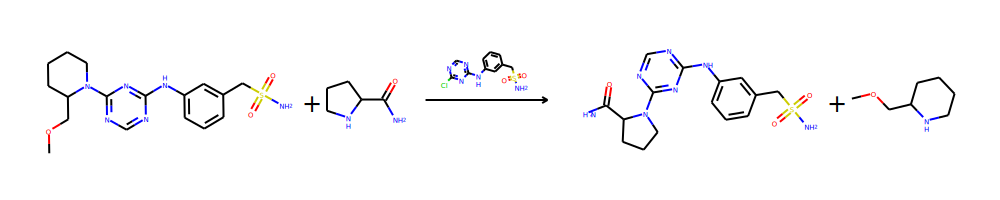

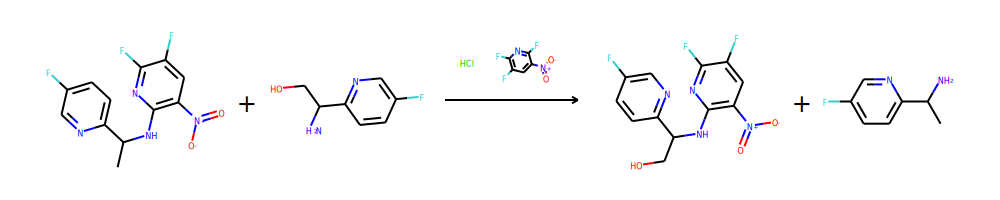

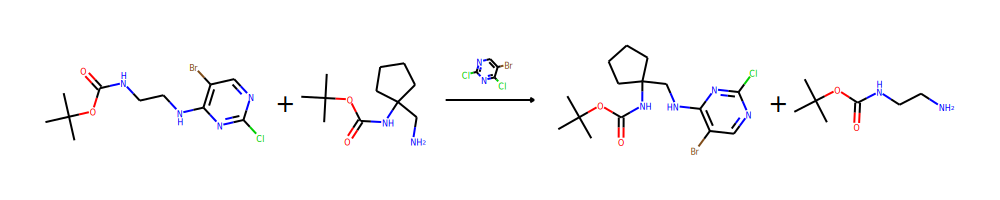

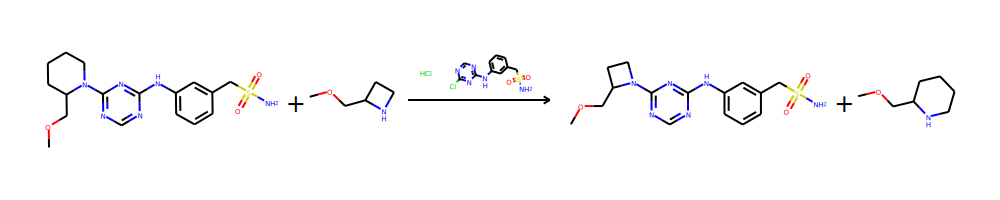

In [28]:
for rsmp in iso_df[iso_df["lg_symbol"] == "N"]["rsmp"]:
    display(SVG(Chem.Draw.ReactionToImage(rsmp.reaction, useSVG=True)))

In [29]:
iso_df.drop(iso_df[iso_df["lg_symbol"] == "N"].index, inplace=True)

# Write csv file

In [30]:
iso_df[["reaction_smiles", "reaction_smiles_no_agent"]].to_csv("processed_reactions.csv")

# Check reactions for chemo- and regioselectivity

In [32]:
patterns = {"F": Chem.MolFromSmarts("[c:1][F]"),
            "Cl": Chem.MolFromSmarts("[c:1][Cl]"),
            "Br": Chem.MolFromSmarts("[c:1][Br]"),
            "I": Chem.MolFromSmarts("[c:1][I]"),
            }

In [33]:
nu_template = Chem.MolFromSmarts("[c:1][Xe]")
xe_pattern = Chem.MolFromSmarts("[Xe]")

In [34]:
reaction_ids = []
competing_reaction_smiles = []
chemos = []
regios = []
majors = []
solvents = []

for reaction_index, row in iso_df.sort_values("product_mw").iterrows():
    rsmp = row["rsmp"]
    substrate = rsmp.substrate
    nu = rsmp.nu
    central_atom = rsmp.central_atom[0]
    orig_leaving_symbol = row["lg_symbol"]
    nu_atom = rsmp.nu_atom[0]
    matches = []
    for symbol, pattern in patterns.items():
        matches.extend([(symbol, match) for match in substrate.GetSubstructMatches(pattern)])
    aromatic_rings = ReactionSmilesProcessor._get_aromatic_rings(substrate)
    reactive_ring = set([ring for ring in aromatic_rings if central_atom in ring][0])
    symmetry_check_atoms = [central_atom]
    if len(matches) > 1:
        reactions  = []
        for symbol, match in matches:
            match = set(match)
            try:
                reactive_atom = reactive_ring.intersection(match).pop()
            except KeyError:
                reactive_atom = None
            if reactive_atom:
                # Test for major/minor
                if central_atom == reactive_atom:
                    major = True
                else:
                    major = False
                    
                # Test for symmetry to see if it is regioselectivity
                symmetry_labeled_atoms = list(Chem.CanonicalRankAtoms(substrate, breakTies=False))
                symmetry_check = [symmetry_labeled_atoms[reactive_atom] == symmetry_labeled_atoms[atom] for atom in symmetry_check_atoms]
                if any(symmetry_check[1:]):
                    continue
                elif symmetry_check[0]:
                    regio = False
                else:
                    regio = True
                    
                # Test if the element is the same to see chemoselectivity
                leaving_atom = match.difference([reactive_atom]).pop()
                leaving_symbol = substrate.GetAtomWithIdx(leaving_atom).GetSymbol()
                if leaving_symbol == orig_leaving_symbol:
                    chemo = False
                else:
                    chemo = True
                
                if not any([chemo, regio, major]):
                    continue 
                    
                # Run transformation
                new_nu = Chem.Mol(nu)
                atom = new_nu.GetAtomWithIdx(nu_atom)
                charge = atom.GetFormalCharge()
                
                # Handle azole nucleophiles
                rings = ReactionSmilesProcessor._get_aromatic_rings(new_nu, merge=False)
                n_h_nu = atom.GetTotalNumHs()
                reactive_rings = [ring for ring in rings if nu_atom in ring]
                ring_ns = []
                if len(reactive_rings) > 0 and n_h_nu == 0 and charge > -1:
                    for i in reactive_rings[0]:
                        new_atom = new_nu.GetAtomWithIdx(i)
                        if new_atom != atom and new_atom.GetSymbol() == "N" and new_atom.GetTotalNumHs() > 0:
                            ring_ns.append(new_atom)
                    if len(ring_ns) > 0 and atom.GetIsAromatic():
                        n_ring_atom = ring_ns[0]
                        n_ring_atom.SetNumExplicitHs(n_ring_atom.GetNumExplicitHs() - 1)
                
                # Handle anionic nucleophiles
                if charge == -1:
                    atom.SetFormalCharge(charge + 1)
                
                # Handle NH3
                if atom.GetTotalNumHs() > 0:
                    atom.SetNumExplicitHs(atom.GetTotalNumHs() - 1)
                    
                xe_substrate = Chem.RWMol(rsmp.substrate)
                xe_substrate.ReplaceAtom(leaving_atom, Chem.Atom(54))
                xe_substrate = xe_substrate.GetMol()
                new_product = Chem.ReplaceSubstructs(xe_substrate, xe_pattern, new_nu, replacementConnectionPoint=nu_atom)[0]
                try:
                    Chem.SanitizeMol(new_product)
                except:
                    display(new_product)

                # Construct new reaction object                
                new_reaction = AllChem.ChemicalReaction()
                new_reaction.AddReactantTemplate(substrate)
                new_reaction.AddReactantTemplate(nu)
                new_reaction.AddProductTemplate(new_product)
                
                # Set up solvent
                if charge < 0:
                    solvent = "Methanol"
                else:
                    solvent = "Acetonitrile"
                
                # Add reactive atom to symmetry check atoms
                symmetry_check_atoms.append(reactive_atom)
                
                reactions.append((new_reaction, major, regio, chemo, solvent))
                
        if len(reactions) > 1:
            for reaction, major, regio, chemo, solvent in reactions:
                reaction_ids.append(reaction_index)
                competing_reaction_smiles.append(AllChem.ReactionToSmiles(reaction))
                majors.append(major)
                regios.append(regio)
                chemos.append(chemo)
                solvents.append(solvent)

In [35]:
data = {"reaction_id": reaction_ids,
        "reaction_smiles": competing_reaction_smiles,
        "major": majors, 
        "regio": regios,
        "chemo": chemos,
        "solvent": solvents,
        }
reaction_df = pd.DataFrame(data)
reaction_df["temperature"] = 298.15
unique_ids = pd.unique(reaction_ids)
print("Number of reactions in total:", len(iso_df))
print("Number of reactions with regio/chemoselectivity questions:", len(unique_ids))

Number of reactions in total: 4353
Number of reactions with regio/chemoselectivity questions: 1209


#### Save data to file

In [36]:
reaction_df.to_csv("competing_reactions.csv")

Pick out 100 reactions and write input for the calculations

In [37]:
top_reactions = unique_ids[:100]
np.save("reaction_ids.npy", top_reactions)
reaction_index = reaction_df["reaction_id"].isin(top_reactions)

In [38]:
reaction_df.loc[reaction_index][["reaction_smiles", "temperature", "solvent"]].to_csv("validation_smiles", sep=" ", header=False, index=False)

Visualize reactions

3023


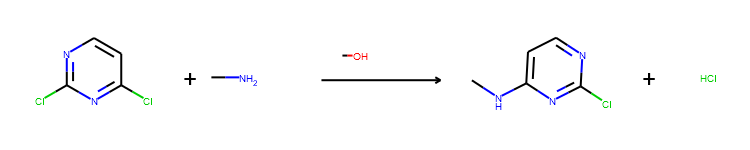

0 CN.Clc1ccnc(Cl)n1>>CNc1ccnc(Cl)n1
Major: True
Regio: False
Chemo: False


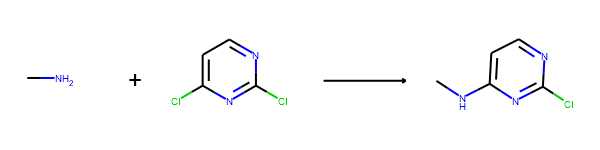

1 CN.Clc1ccnc(Cl)n1>>CNc1nccc(Cl)n1
Major: False
Regio: True
Chemo: False


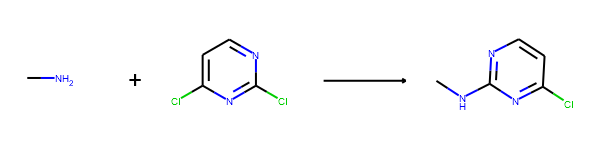

1771


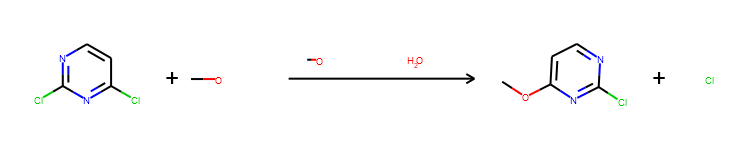

2 C[O-].Clc1ccnc(Cl)n1>>COc1ccnc(Cl)n1
Major: True
Regio: False
Chemo: False


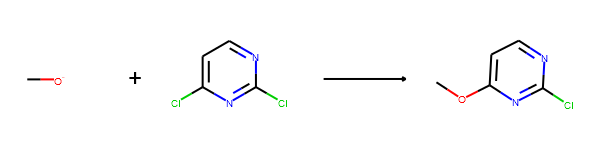

3 C[O-].Clc1ccnc(Cl)n1>>COc1nccc(Cl)n1
Major: False
Regio: True
Chemo: False


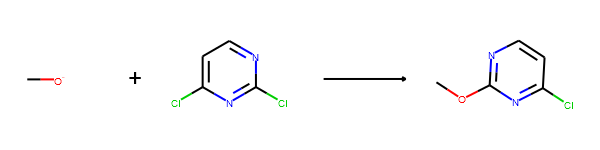

1124


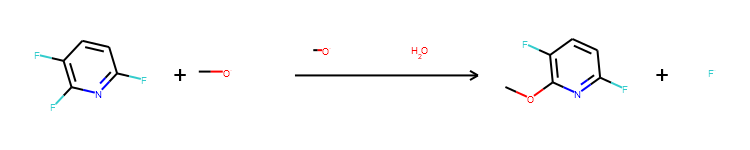

4 C[O-].Fc1ccc(F)c(F)n1>>COc1ccc(F)c(F)n1
Major: False
Regio: True
Chemo: False


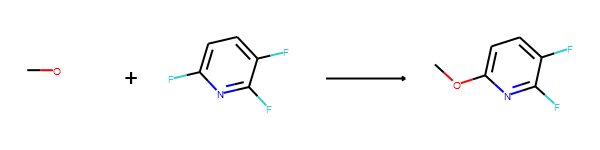

5 C[O-].Fc1ccc(F)c(F)n1>>COc1nc(F)ccc1F
Major: True
Regio: False
Chemo: False


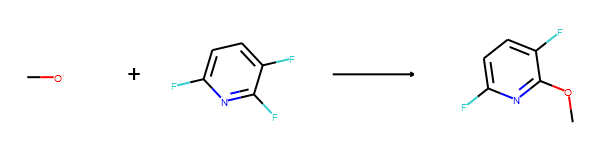

6 C[O-].Fc1ccc(F)c(F)n1>>COc1ccc(F)nc1F
Major: False
Regio: True
Chemo: False


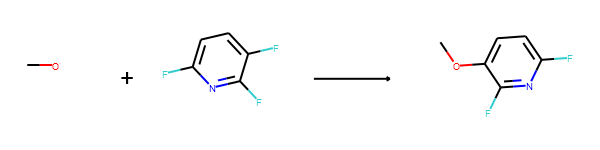

4003


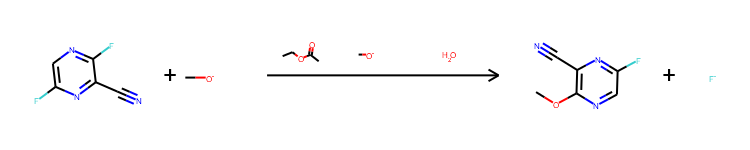

7 C[O-].N#Cc1nc(F)cnc1F>>COc1cnc(F)c(C#N)n1
Major: False
Regio: True
Chemo: False


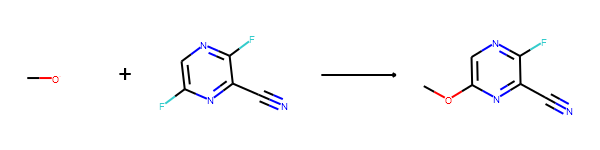

8 C[O-].N#Cc1nc(F)cnc1F>>COc1ncc(F)nc1C#N
Major: True
Regio: False
Chemo: False


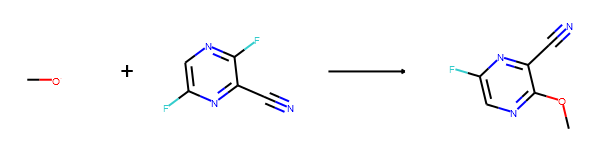

2087


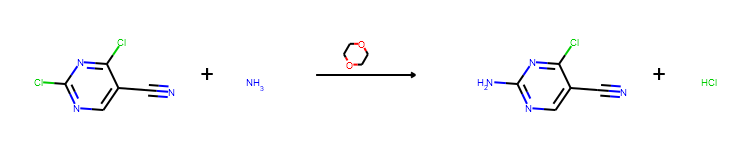

9 N.N#Cc1cnc(Cl)nc1Cl>>N#Cc1cnc(N)nc1Cl
Major: True
Regio: False
Chemo: False


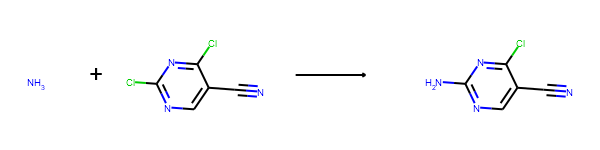

10 N.N#Cc1cnc(Cl)nc1Cl>>N#Cc1cnc(Cl)nc1N
Major: False
Regio: True
Chemo: False


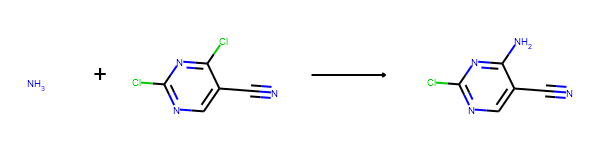

358


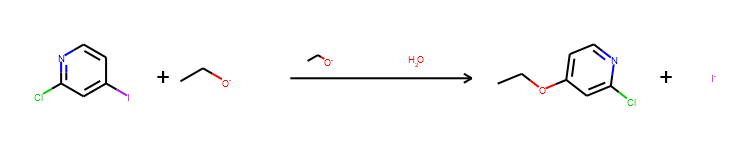

11 CC[O-].Clc1cc(I)ccn1>>CCOc1cc(I)ccn1
Major: False
Regio: True
Chemo: True


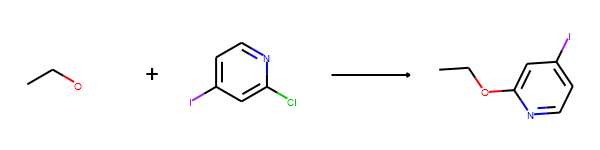

12 CC[O-].Clc1cc(I)ccn1>>CCOc1ccnc(Cl)c1
Major: True
Regio: False
Chemo: False


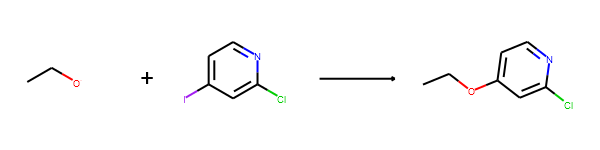

1807


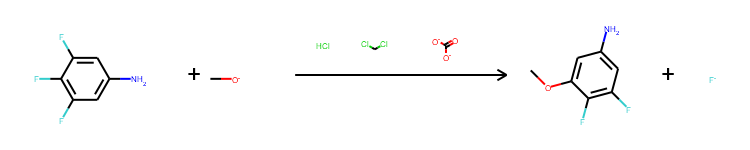

13 C[O-].Nc1cc(F)c(F)c(F)c1>>COc1cc(N)cc(F)c1F
Major: True
Regio: False
Chemo: False


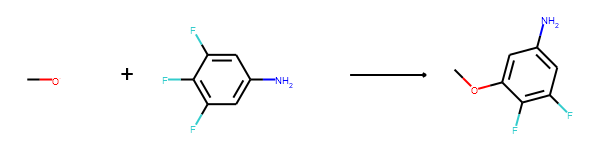

14 C[O-].Nc1cc(F)c(F)c(F)c1>>COc1c(F)cc(N)cc1F
Major: False
Regio: True
Chemo: False


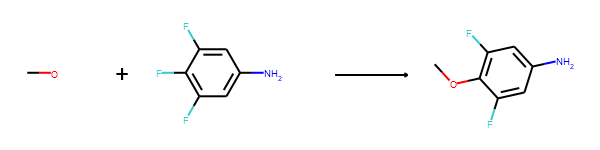

3065


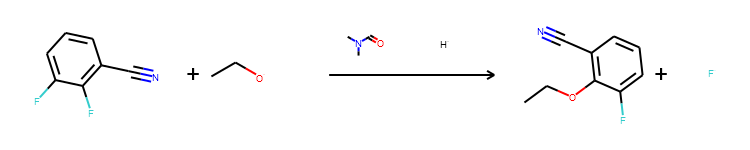

15 CC[O-].N#Cc1cccc(F)c1F>>CCOc1c(F)cccc1C#N
Major: True
Regio: False
Chemo: False


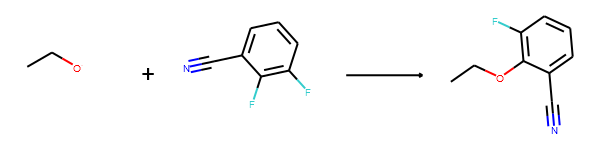

16 CC[O-].N#Cc1cccc(F)c1F>>CCOc1cccc(C#N)c1F
Major: False
Regio: True
Chemo: False


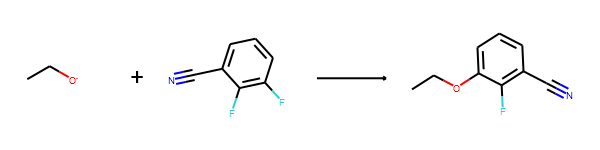

3708


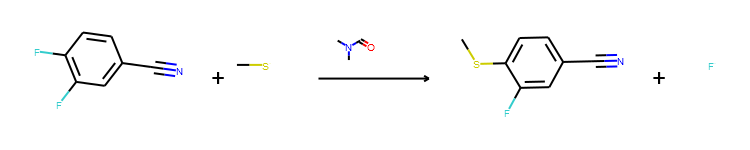

17 C[S-].N#Cc1ccc(F)c(F)c1>>CSc1cc(C#N)ccc1F
Major: False
Regio: True
Chemo: False


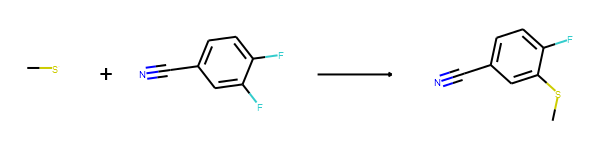

18 C[S-].N#Cc1ccc(F)c(F)c1>>CSc1ccc(C#N)cc1F
Major: True
Regio: False
Chemo: False


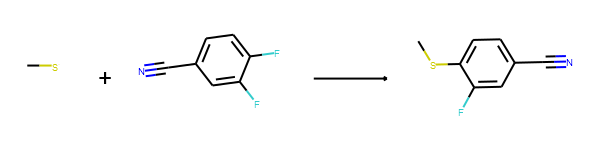

1679


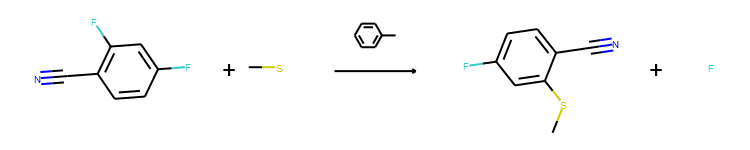

19 C[S-].N#Cc1ccc(F)cc1F>>CSc1cc(F)ccc1C#N
Major: True
Regio: False
Chemo: False


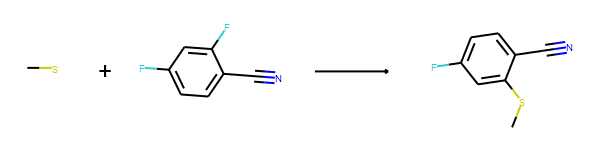

20 C[S-].N#Cc1ccc(F)cc1F>>CSc1ccc(C#N)c(F)c1
Major: False
Regio: True
Chemo: False


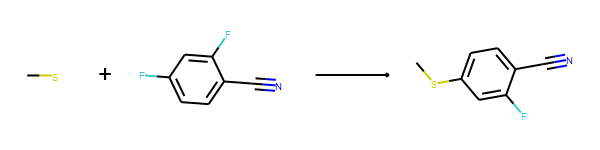

2695


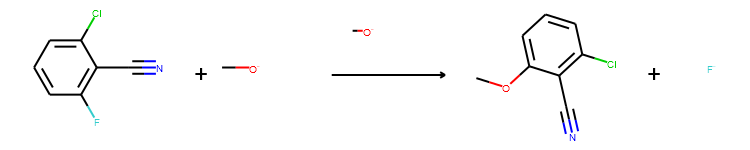

21 C[O-].N#Cc1c(F)cccc1Cl>>COc1cccc(Cl)c1C#N
Major: True
Regio: False
Chemo: False


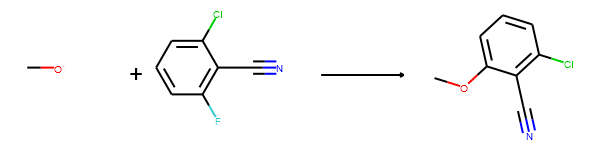

22 C[O-].N#Cc1c(F)cccc1Cl>>COc1cccc(F)c1C#N
Major: False
Regio: True
Chemo: True


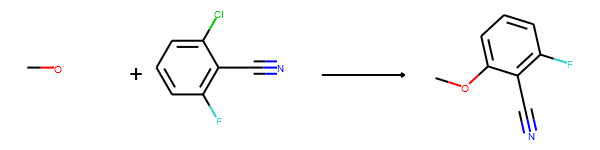

897


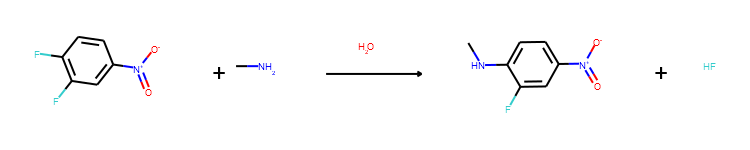

23 CN.O=[N+]([O-])c1ccc(F)c(F)c1>>CNc1cc([N+](=O)[O-])ccc1F
Major: False
Regio: True
Chemo: False


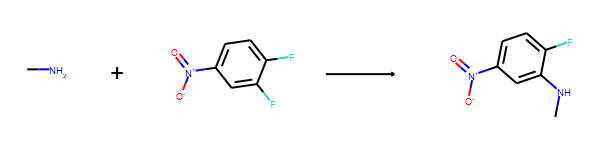

24 CN.O=[N+]([O-])c1ccc(F)c(F)c1>>CNc1ccc([N+](=O)[O-])cc1F
Major: True
Regio: False
Chemo: False


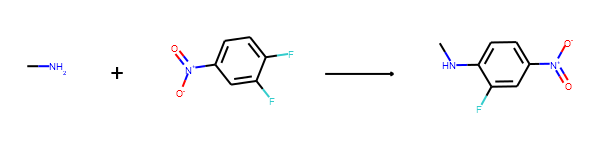

1


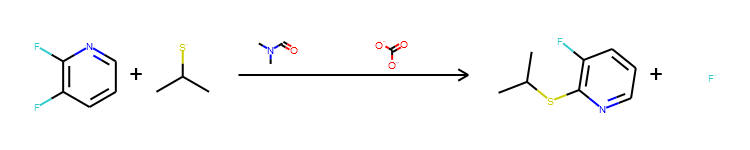

25 CC(C)[S-].Fc1cccnc1F>>CC(C)Sc1cccnc1F
Major: False
Regio: True
Chemo: False


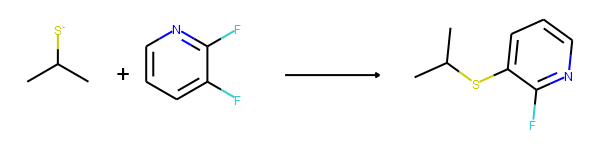

26 CC(C)[S-].Fc1cccnc1F>>CC(C)Sc1ncccc1F
Major: True
Regio: False
Chemo: False


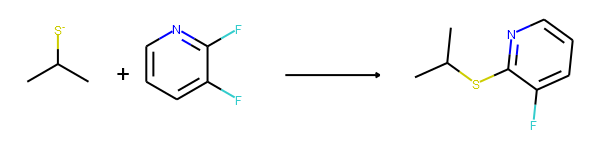

1699


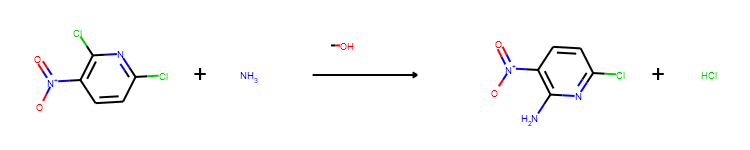

27 N.O=[N+]([O-])c1ccc(Cl)nc1Cl>>Nc1nc(Cl)ccc1[N+](=O)[O-]
Major: True
Regio: False
Chemo: False


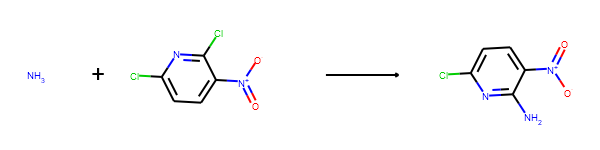

28 N.O=[N+]([O-])c1ccc(Cl)nc1Cl>>Nc1ccc([N+](=O)[O-])c(Cl)n1
Major: False
Regio: True
Chemo: False


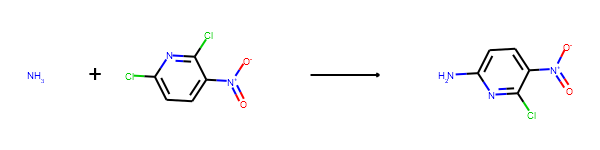

1472


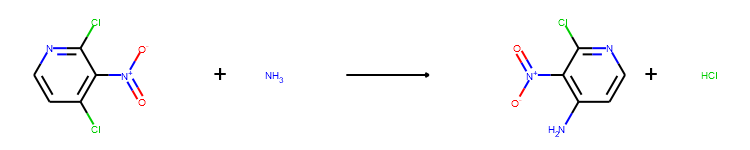

29 N.O=[N+]([O-])c1c(Cl)ccnc1Cl>>Nc1ccnc(Cl)c1[N+](=O)[O-]
Major: True
Regio: False
Chemo: False


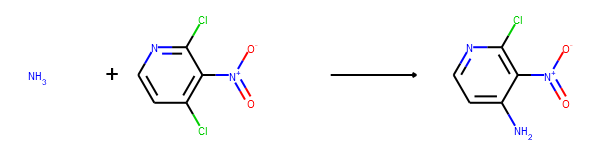

30 N.O=[N+]([O-])c1c(Cl)ccnc1Cl>>Nc1nccc(Cl)c1[N+](=O)[O-]
Major: False
Regio: True
Chemo: False


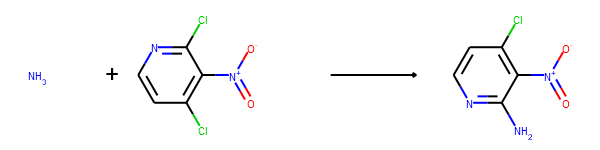

2749


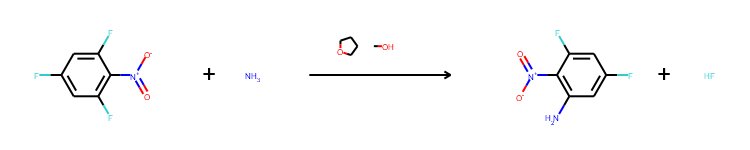

31 N.O=[N+]([O-])c1c(F)cc(F)cc1F>>Nc1cc(F)cc(F)c1[N+](=O)[O-]
Major: True
Regio: False
Chemo: False


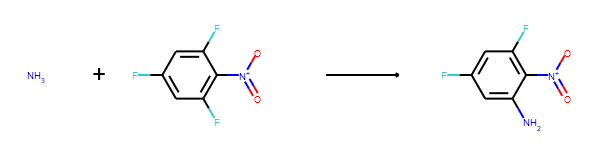

32 N.O=[N+]([O-])c1c(F)cc(F)cc1F>>Nc1cc(F)c([N+](=O)[O-])c(F)c1
Major: False
Regio: True
Chemo: False


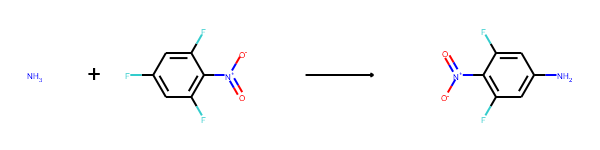

1236


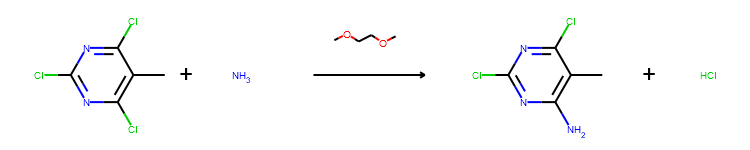

33 Cc1c(Cl)nc(Cl)nc1Cl.N>>Cc1c(N)nc(Cl)nc1Cl
Major: True
Regio: False
Chemo: False


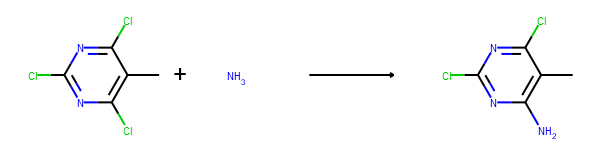

34 Cc1c(Cl)nc(Cl)nc1Cl.N>>Cc1c(Cl)nc(N)nc1Cl
Major: False
Regio: True
Chemo: False


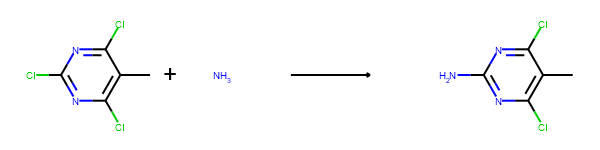

375


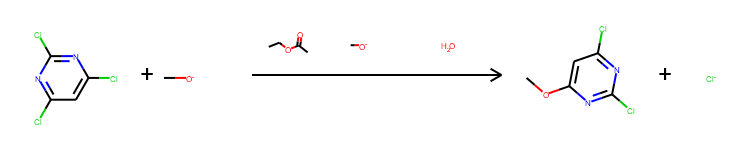

35 C[O-].Clc1cc(Cl)nc(Cl)n1>>COc1cc(Cl)nc(Cl)n1
Major: True
Regio: False
Chemo: False


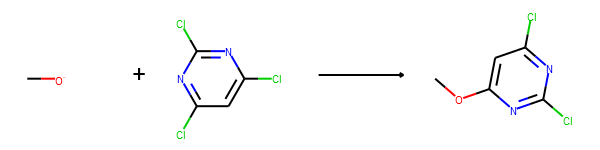

36 C[O-].Clc1cc(Cl)nc(Cl)n1>>COc1nc(Cl)cc(Cl)n1
Major: False
Regio: True
Chemo: False


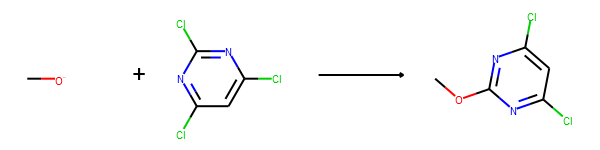

1841


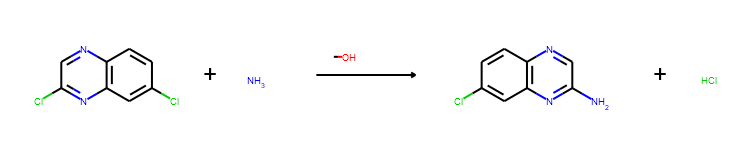

37 Clc1ccc2ncc(Cl)nc2c1.N>>Nc1ccc2ncc(Cl)nc2c1
Major: False
Regio: True
Chemo: False


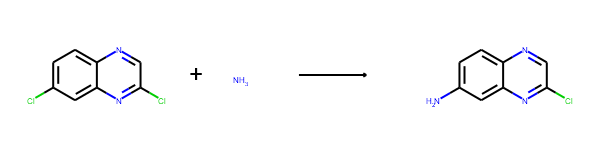

38 Clc1ccc2ncc(Cl)nc2c1.N>>Nc1cnc2ccc(Cl)cc2n1
Major: True
Regio: False
Chemo: False


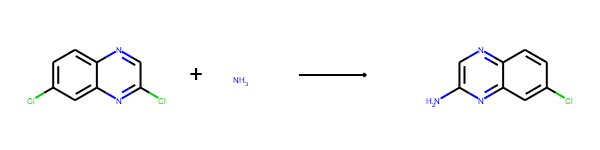

129


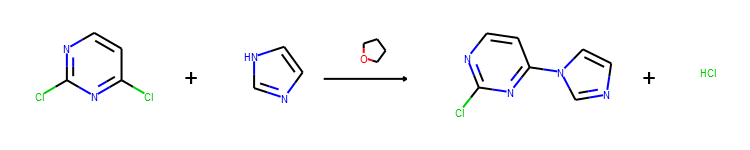

39 Clc1ccnc(Cl)n1.c1c[nH]cn1>>Clc1nccc(-n2ccnc2)n1
Major: True
Regio: False
Chemo: False


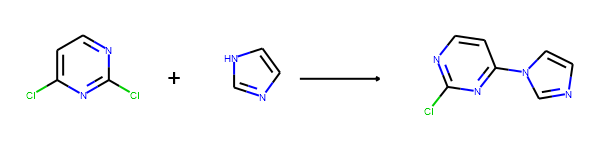

40 Clc1ccnc(Cl)n1.c1c[nH]cn1>>Clc1ccnc(-n2ccnc2)n1
Major: False
Regio: True
Chemo: False


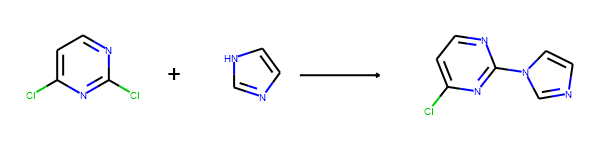

1586


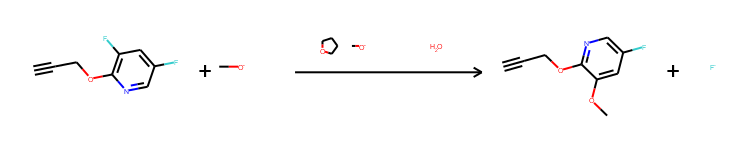

41 C#CCOc1ncc(F)cc1F.C[O-]>>C#CCOc1ncc(F)cc1OC
Major: True
Regio: False
Chemo: False


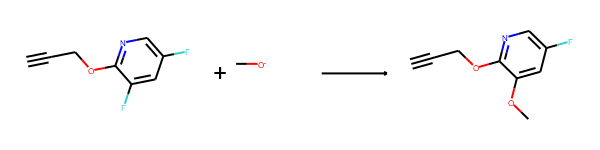

42 C#CCOc1ncc(F)cc1F.C[O-]>>C#CCOc1ncc(OC)cc1F
Major: False
Regio: True
Chemo: False


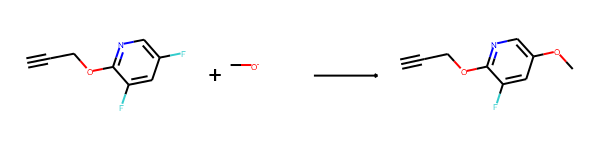

3901


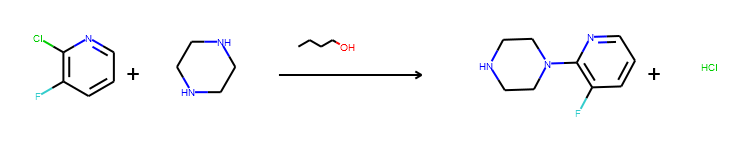

43 C1CNCCN1.Fc1cccnc1Cl>>Clc1ncccc1N1CCNCC1
Major: False
Regio: True
Chemo: True


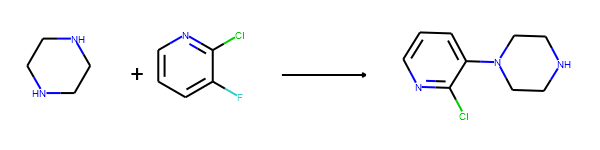

44 C1CNCCN1.Fc1cccnc1Cl>>Fc1cccnc1N1CCNCC1
Major: True
Regio: False
Chemo: False


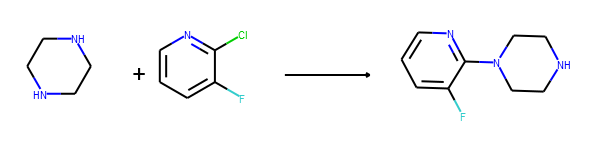

548


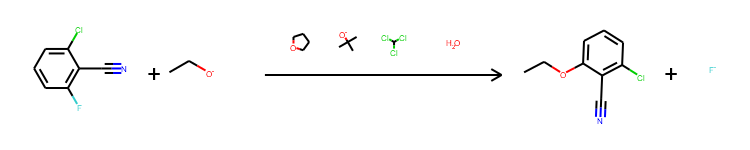

45 CC[O-].N#Cc1c(F)cccc1Cl>>CCOc1cccc(Cl)c1C#N
Major: True
Regio: False
Chemo: False


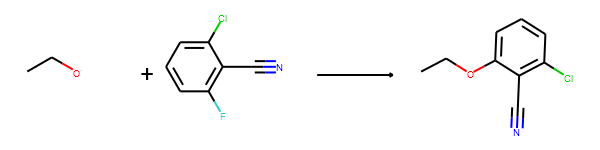

46 CC[O-].N#Cc1c(F)cccc1Cl>>CCOc1cccc(F)c1C#N
Major: False
Regio: True
Chemo: True


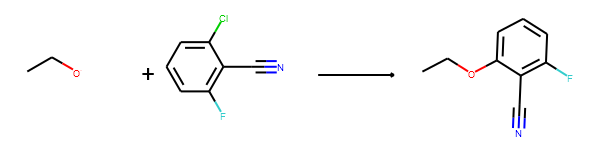

68


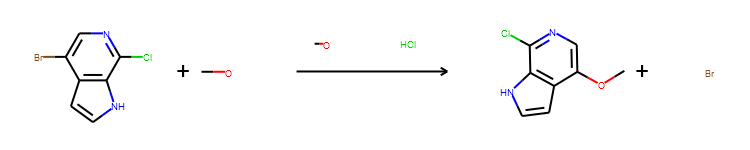

47 C[O-].Clc1ncc(Br)c2cc[nH]c12>>COc1ncc(Br)c2cc[nH]c12
Major: False
Regio: True
Chemo: True


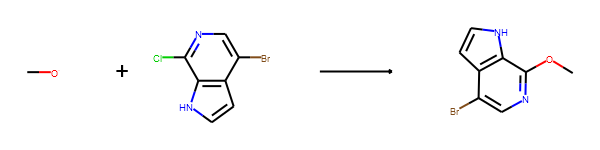

48 C[O-].Clc1ncc(Br)c2cc[nH]c12>>COc1cnc(Cl)c2[nH]ccc12
Major: True
Regio: False
Chemo: False


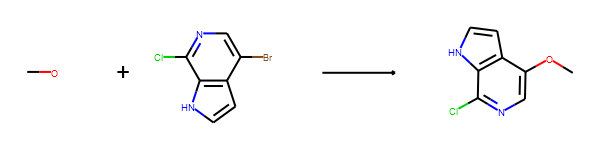

2855


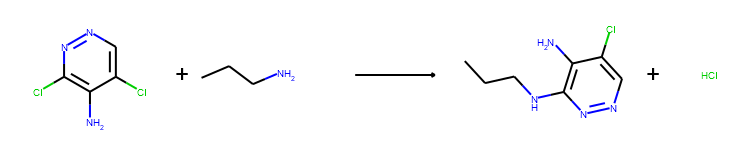

49 CCCN.Nc1c(Cl)cnnc1Cl>>CCCNc1nncc(Cl)c1N
Major: True
Regio: False
Chemo: False


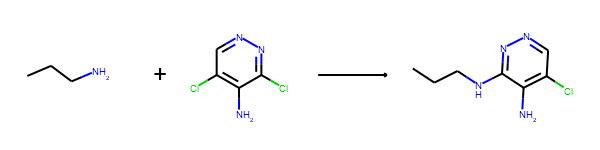

50 CCCN.Nc1c(Cl)cnnc1Cl>>CCCNc1cnnc(Cl)c1N
Major: False
Regio: True
Chemo: False


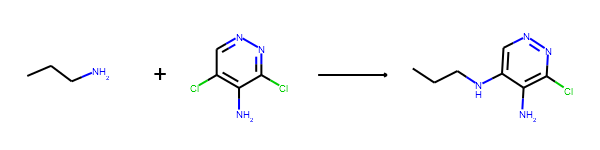

578


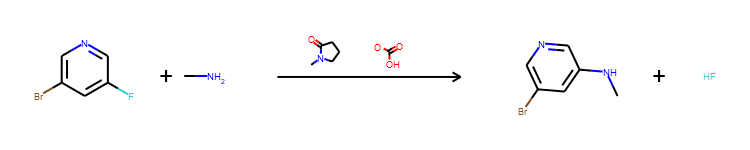

51 CN.Fc1cncc(Br)c1>>CNc1cncc(Br)c1
Major: True
Regio: False
Chemo: False


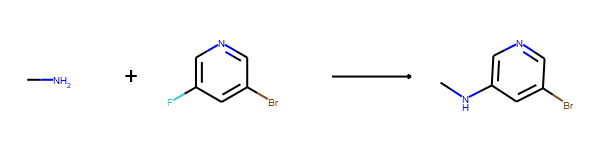

52 CN.Fc1cncc(Br)c1>>CNc1cncc(F)c1
Major: False
Regio: True
Chemo: True


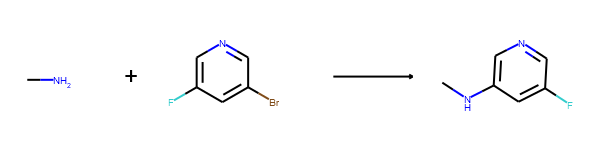

2096


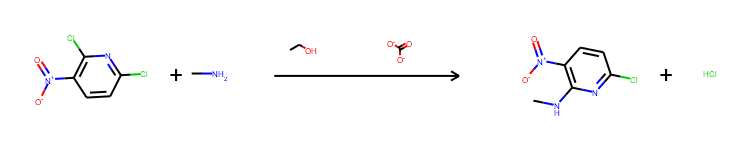

53 CN.O=[N+]([O-])c1ccc(Cl)nc1Cl>>CNc1nc(Cl)ccc1[N+](=O)[O-]
Major: True
Regio: False
Chemo: False


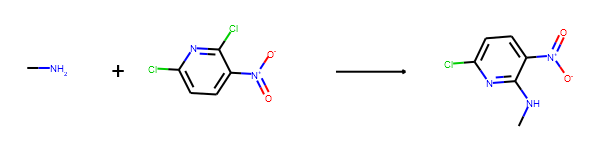

54 CN.O=[N+]([O-])c1ccc(Cl)nc1Cl>>CNc1ccc([N+](=O)[O-])c(Cl)n1
Major: False
Regio: True
Chemo: False


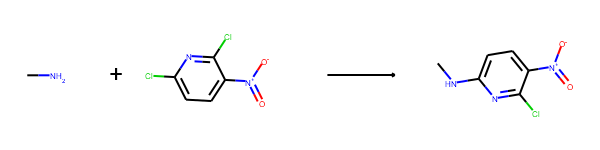

4252


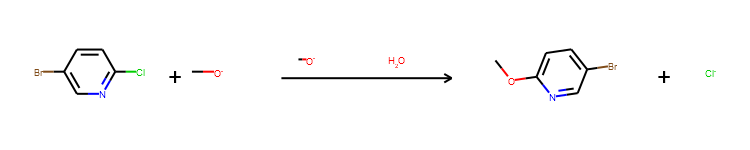

55 C[O-].Clc1ccc(Br)cn1>>COc1ccc(Br)cn1
Major: True
Regio: False
Chemo: False


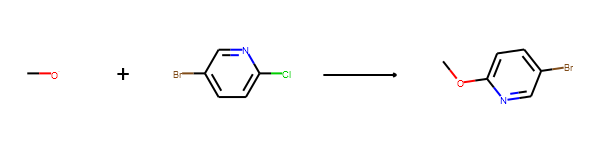

56 C[O-].Clc1ccc(Br)cn1>>COc1ccc(Cl)nc1
Major: False
Regio: True
Chemo: True


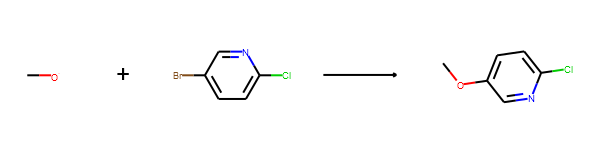

1349


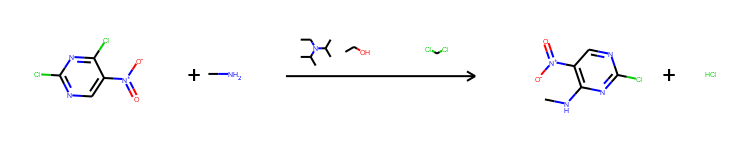

57 CN.O=[N+]([O-])c1cnc(Cl)nc1Cl>>CNc1ncc([N+](=O)[O-])c(Cl)n1
Major: False
Regio: True
Chemo: False


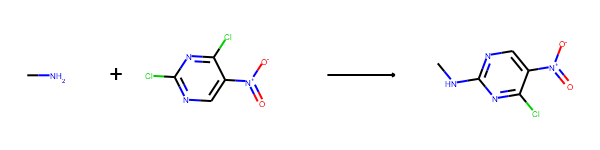

58 CN.O=[N+]([O-])c1cnc(Cl)nc1Cl>>CNc1nc(Cl)ncc1[N+](=O)[O-]
Major: True
Regio: False
Chemo: False


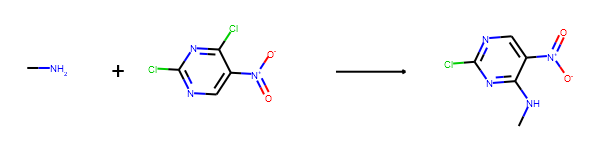

3176


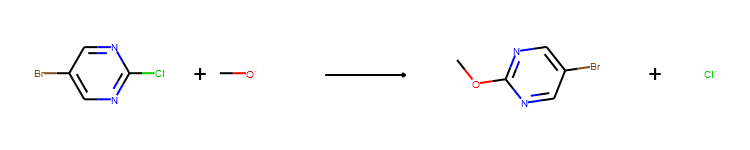

59 C[O-].Clc1ncc(Br)cn1>>COc1ncc(Br)cn1
Major: True
Regio: False
Chemo: False


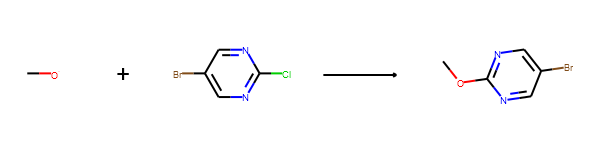

60 C[O-].Clc1ncc(Br)cn1>>COc1cnc(Cl)nc1
Major: False
Regio: True
Chemo: True


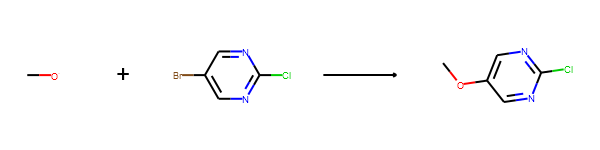

2842


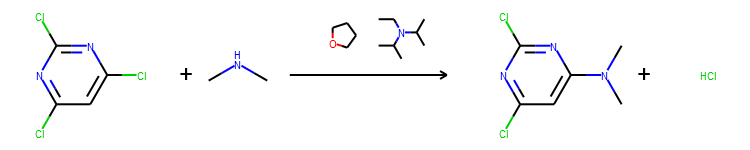

61 CNC.Clc1cc(Cl)nc(Cl)n1>>CN(C)c1cc(Cl)nc(Cl)n1
Major: True
Regio: False
Chemo: False


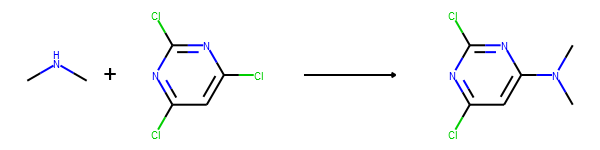

62 CNC.Clc1cc(Cl)nc(Cl)n1>>CN(C)c1nc(Cl)cc(Cl)n1
Major: False
Regio: True
Chemo: False


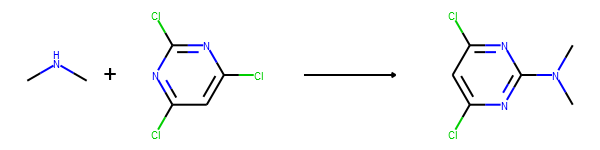

2905


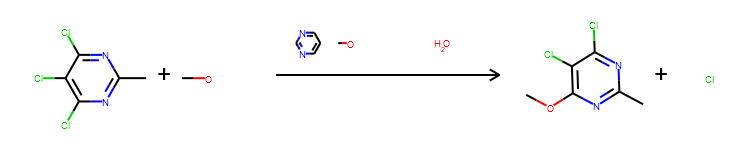

63 C[O-].Cc1nc(Cl)c(Cl)c(Cl)n1>>COc1nc(C)nc(Cl)c1Cl
Major: True
Regio: False
Chemo: False


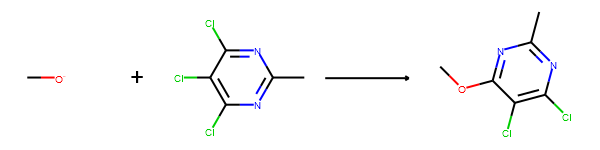

64 C[O-].Cc1nc(Cl)c(Cl)c(Cl)n1>>COc1c(Cl)nc(C)nc1Cl
Major: False
Regio: True
Chemo: False


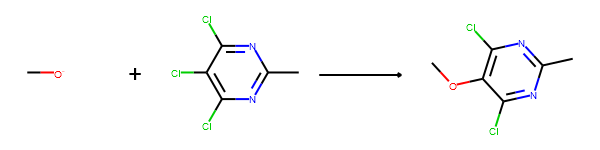

2190


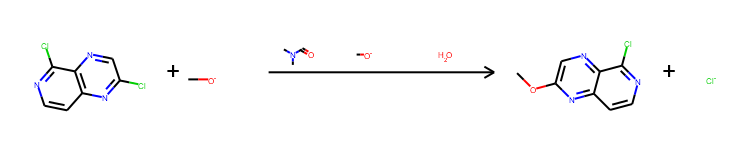

65 C[O-].Clc1cnc2c(Cl)nccc2n1>>COc1cnc2c(Cl)nccc2n1
Major: True
Regio: False
Chemo: False


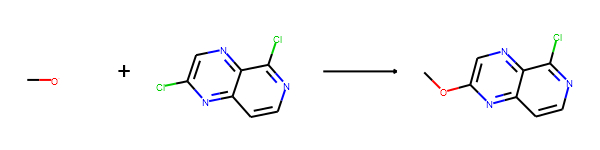

66 C[O-].Clc1cnc2c(Cl)nccc2n1>>COc1nccc2nc(Cl)cnc12
Major: False
Regio: True
Chemo: False


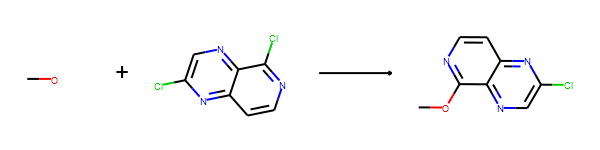

2062


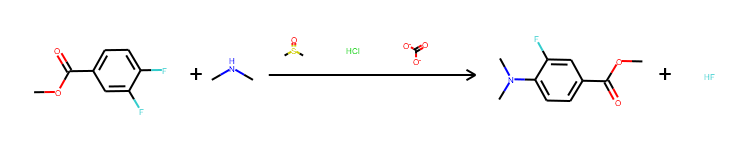

67 CNC.COC(=O)c1ccc(F)c(F)c1>>COC(=O)c1ccc(N(C)C)c(F)c1
Major: True
Regio: False
Chemo: False


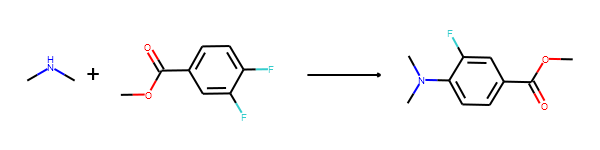

68 CNC.COC(=O)c1ccc(F)c(F)c1>>COC(=O)c1ccc(F)c(N(C)C)c1
Major: False
Regio: True
Chemo: False


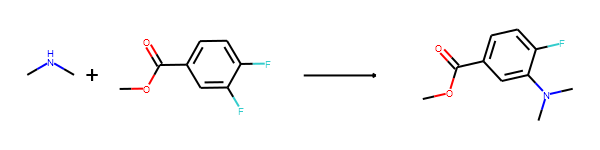

3589


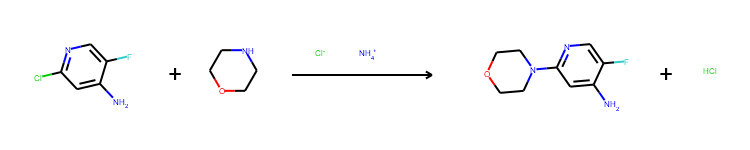

69 C1COCCN1.Nc1cc(Cl)ncc1F>>Nc1cc(Cl)ncc1N1CCOCC1
Major: False
Regio: True
Chemo: True


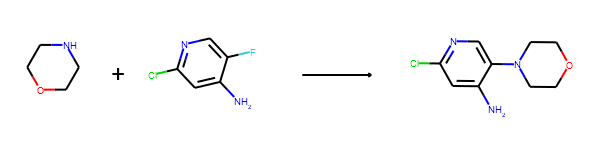

70 C1COCCN1.Nc1cc(Cl)ncc1F>>Nc1cc(N2CCOCC2)ncc1F
Major: True
Regio: False
Chemo: False


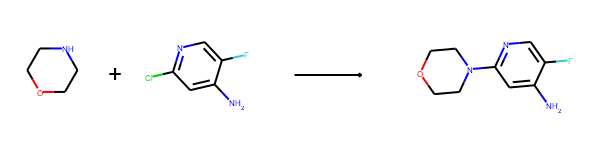

2592


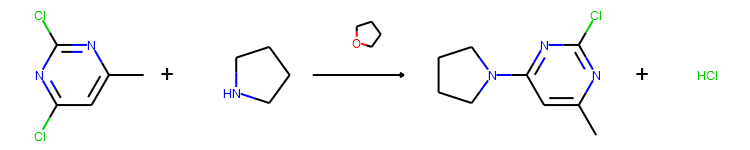

71 C1CCNC1.Cc1cc(Cl)nc(Cl)n1>>Cc1cc(N2CCCC2)nc(Cl)n1
Major: True
Regio: False
Chemo: False


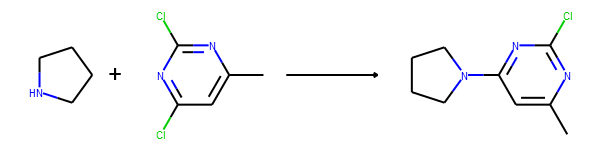

72 C1CCNC1.Cc1cc(Cl)nc(Cl)n1>>Cc1cc(Cl)nc(N2CCCC2)n1
Major: False
Regio: True
Chemo: False


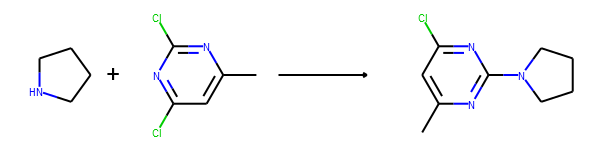

364


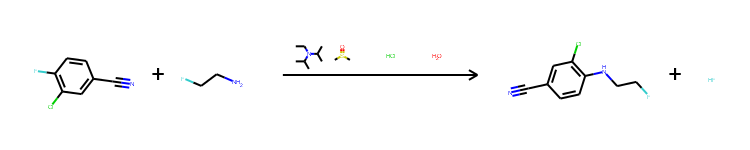

73 N#Cc1ccc(F)c(Cl)c1.NCCF>>N#Cc1ccc(NCCF)c(Cl)c1
Major: True
Regio: False
Chemo: False


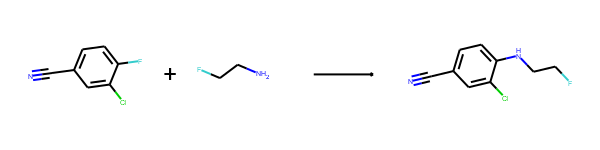

74 N#Cc1ccc(F)c(Cl)c1.NCCF>>N#Cc1ccc(F)c(NCCF)c1
Major: False
Regio: True
Chemo: True


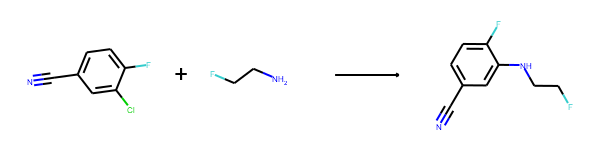

2440


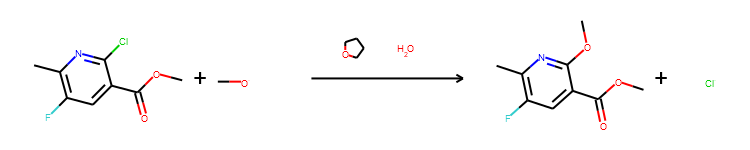

75 COC(=O)c1cc(F)c(C)nc1Cl.C[O-]>>COC(=O)c1cc(OC)c(C)nc1Cl
Major: False
Regio: True
Chemo: True


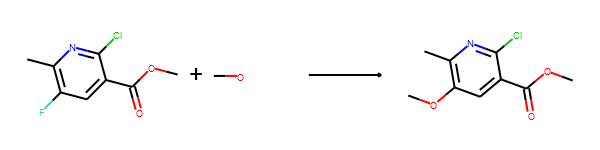

76 COC(=O)c1cc(F)c(C)nc1Cl.C[O-]>>COC(=O)c1cc(F)c(C)nc1OC
Major: True
Regio: False
Chemo: False


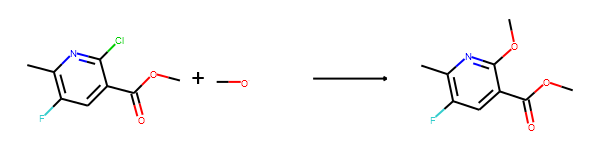

1154


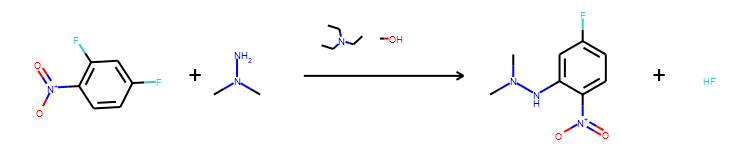

77 CN(C)N.O=[N+]([O-])c1ccc(F)cc1F>>CN(C)Nc1cc(F)ccc1[N+](=O)[O-]
Major: True
Regio: False
Chemo: False


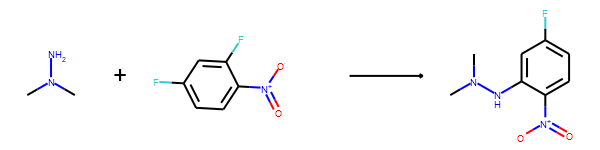

78 CN(C)N.O=[N+]([O-])c1ccc(F)cc1F>>CN(C)Nc1ccc([N+](=O)[O-])c(F)c1
Major: False
Regio: True
Chemo: False


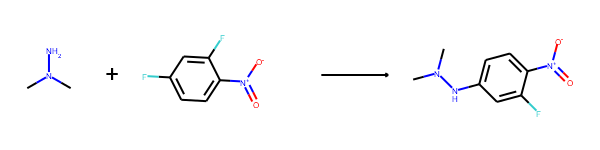

1891


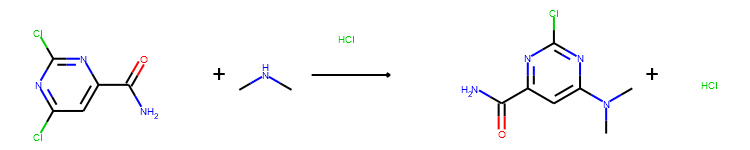

79 CNC.NC(=O)c1cc(Cl)nc(Cl)n1>>CN(C)c1cc(C(N)=O)nc(Cl)n1
Major: True
Regio: False
Chemo: False


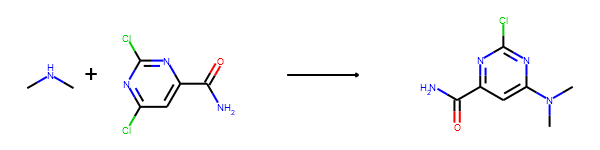

80 CNC.NC(=O)c1cc(Cl)nc(Cl)n1>>CN(C)c1nc(Cl)cc(C(N)=O)n1
Major: False
Regio: True
Chemo: False


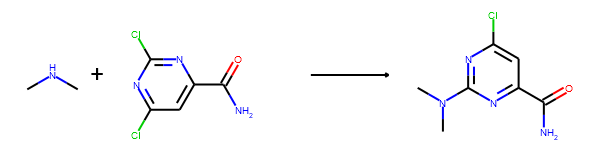

3109


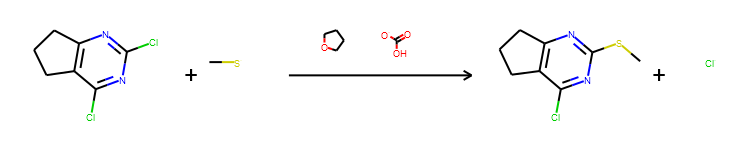

81 C[S-].Clc1nc(Cl)c2c(n1)CCC2>>CSc1nc(Cl)c2c(n1)CCC2
Major: True
Regio: False
Chemo: False


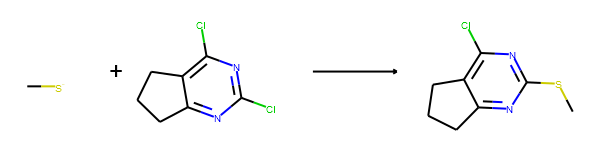

82 C[S-].Clc1nc(Cl)c2c(n1)CCC2>>CSc1nc(Cl)nc2c1CCC2
Major: False
Regio: True
Chemo: False


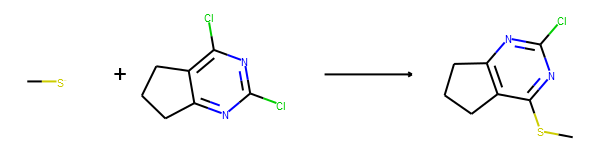

2970


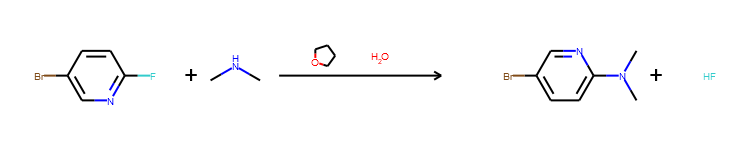

83 CNC.Fc1ccc(Br)cn1>>CN(C)c1ccc(Br)cn1
Major: True
Regio: False
Chemo: False


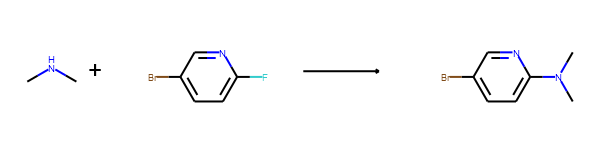

84 CNC.Fc1ccc(Br)cn1>>CN(C)c1ccc(F)nc1
Major: False
Regio: True
Chemo: True


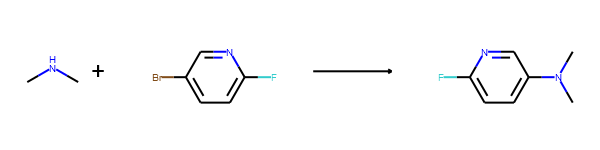

3863


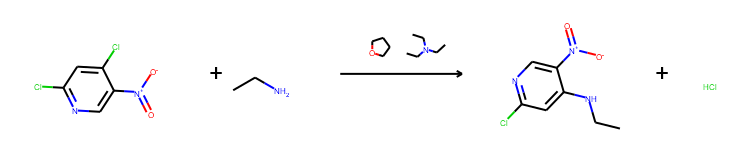

85 CCN.O=[N+]([O-])c1cnc(Cl)cc1Cl>>CCNc1cc(Cl)c([N+](=O)[O-])cn1
Major: False
Regio: True
Chemo: False


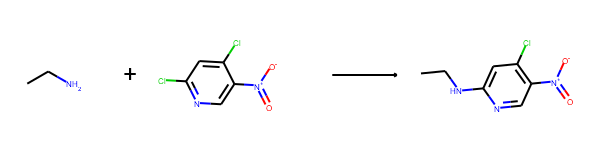

86 CCN.O=[N+]([O-])c1cnc(Cl)cc1Cl>>CCNc1cc(Cl)ncc1[N+](=O)[O-]
Major: True
Regio: False
Chemo: False


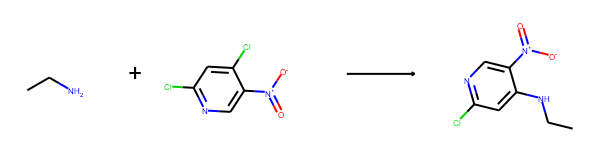

2162


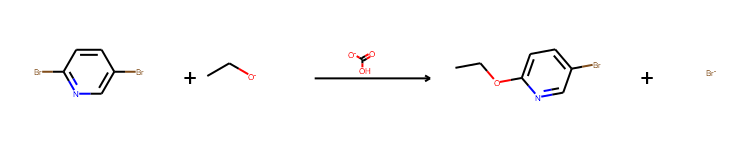

87 Brc1ccc(Br)nc1.CC[O-]>>CCOc1ccc(Br)nc1
Major: False
Regio: True
Chemo: False


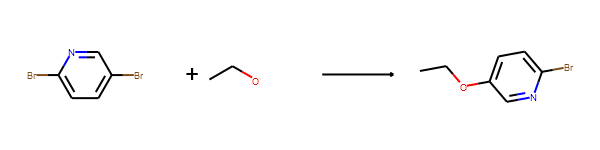

88 Brc1ccc(Br)nc1.CC[O-]>>CCOc1ccc(Br)cn1
Major: True
Regio: False
Chemo: False


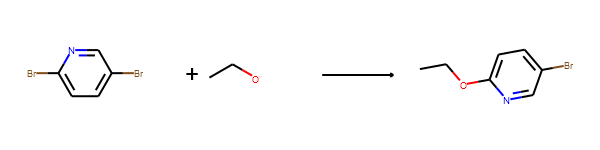

4357


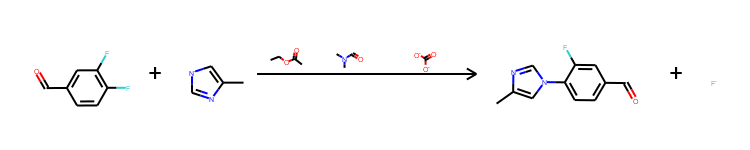

89 Cc1c[n-]cn1.O=Cc1ccc(F)c(F)c1>>Cc1cn(-c2cc(C=O)ccc2F)cn1
Major: False
Regio: True
Chemo: False


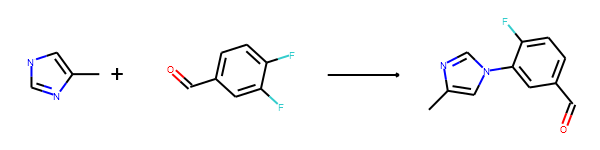

90 Cc1c[n-]cn1.O=Cc1ccc(F)c(F)c1>>Cc1cn(-c2ccc(C=O)cc2F)cn1
Major: True
Regio: False
Chemo: False


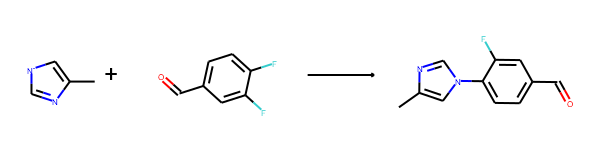

1788


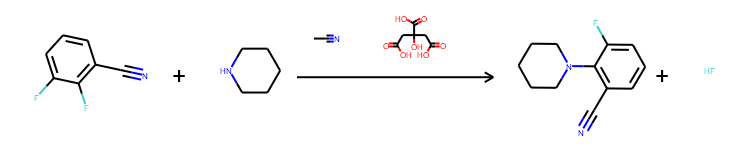

91 C1CCNCC1.N#Cc1cccc(F)c1F>>N#Cc1cccc(F)c1N1CCCCC1
Major: True
Regio: False
Chemo: False


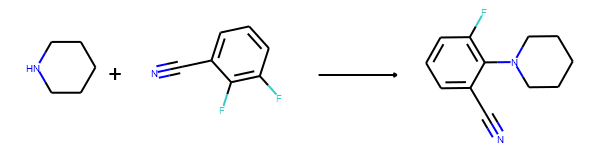

92 C1CCNCC1.N#Cc1cccc(F)c1F>>N#Cc1cccc(N2CCCCC2)c1F
Major: False
Regio: True
Chemo: False


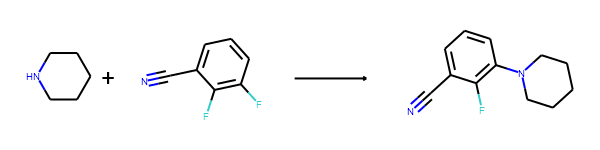

2727


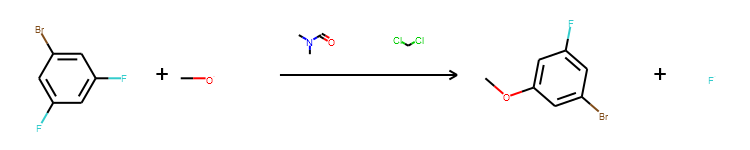

93 C[O-].Fc1cc(F)cc(Br)c1>>COc1cc(F)cc(Br)c1
Major: True
Regio: False
Chemo: False


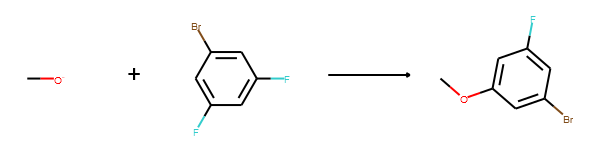

94 C[O-].Fc1cc(F)cc(Br)c1>>COc1cc(F)cc(F)c1
Major: False
Regio: True
Chemo: True


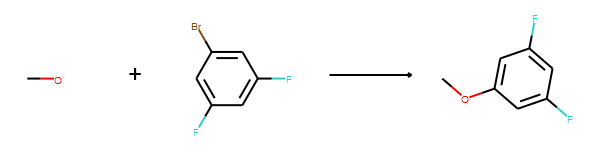

4163


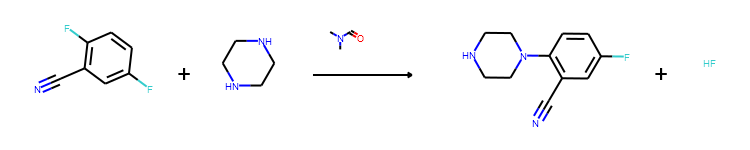

95 C1CNCCN1.N#Cc1cc(F)ccc1F>>N#Cc1cc(F)ccc1N1CCNCC1
Major: True
Regio: False
Chemo: False


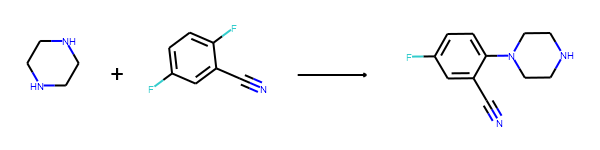

96 C1CNCCN1.N#Cc1cc(F)ccc1F>>N#Cc1cc(N2CCNCC2)ccc1F
Major: False
Regio: True
Chemo: False


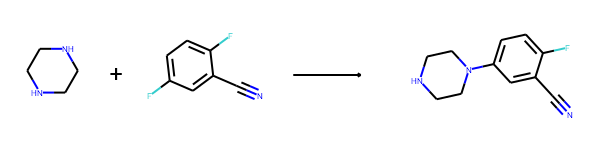

1041


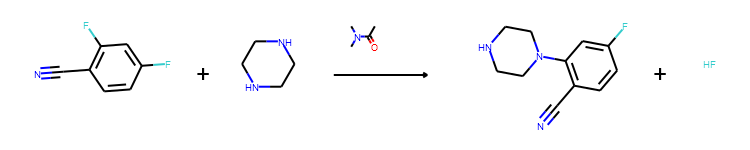

97 C1CNCCN1.N#Cc1ccc(F)cc1F>>N#Cc1ccc(F)cc1N1CCNCC1
Major: True
Regio: False
Chemo: False


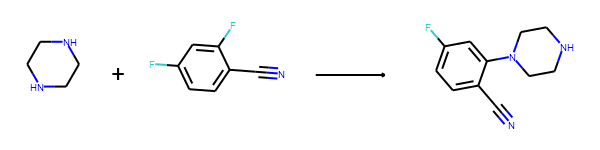

98 C1CNCCN1.N#Cc1ccc(F)cc1F>>N#Cc1ccc(N2CCNCC2)cc1F
Major: False
Regio: True
Chemo: False


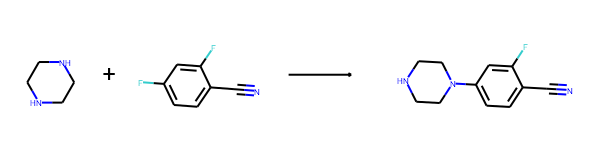

3656


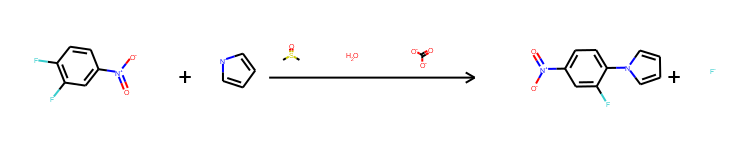

99 O=[N+]([O-])c1ccc(F)c(F)c1.c1cc[n-]c1>>O=[N+]([O-])c1ccc(F)c(-n2cccc2)c1
Major: False
Regio: True
Chemo: False


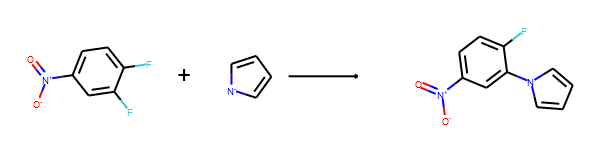

100 O=[N+]([O-])c1ccc(F)c(F)c1.c1cc[n-]c1>>O=[N+]([O-])c1ccc(-n2cccc2)c(F)c1
Major: True
Regio: False
Chemo: False


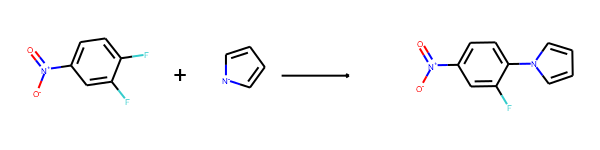

2482


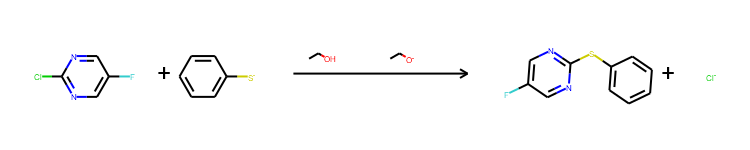

101 Fc1cnc(Cl)nc1.[S-]c1ccccc1>>Clc1ncc(Sc2ccccc2)cn1
Major: False
Regio: True
Chemo: True


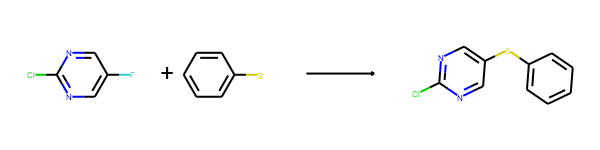

102 Fc1cnc(Cl)nc1.[S-]c1ccccc1>>Fc1cnc(Sc2ccccc2)nc1
Major: True
Regio: False
Chemo: False


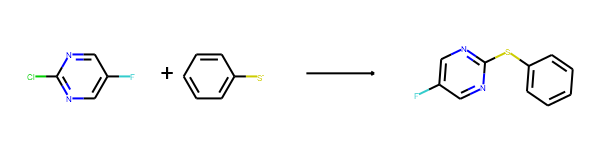

4367


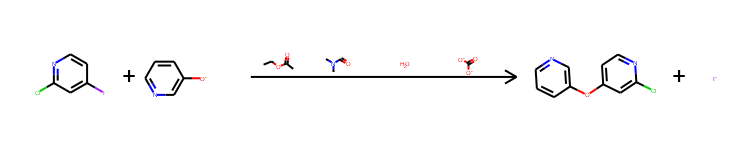

103 Clc1cc(I)ccn1.[O-]c1cccnc1>>Ic1ccnc(Oc2cccnc2)c1
Major: False
Regio: True
Chemo: True


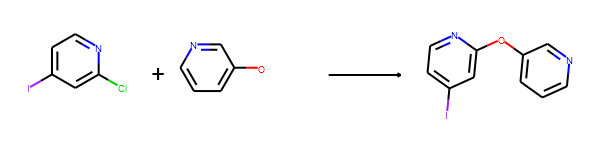

104 Clc1cc(I)ccn1.[O-]c1cccnc1>>Clc1cc(Oc2cccnc2)ccn1
Major: True
Regio: False
Chemo: False


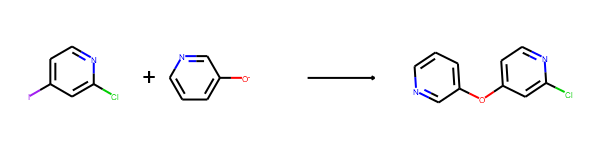

412


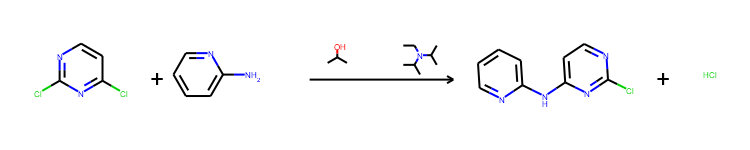

105 Clc1ccnc(Cl)n1.Nc1ccccn1>>Clc1nccc(Nc2ccccn2)n1
Major: True
Regio: False
Chemo: False


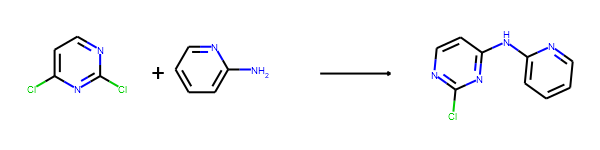

106 Clc1ccnc(Cl)n1.Nc1ccccn1>>Clc1ccnc(Nc2ccccn2)n1
Major: False
Regio: True
Chemo: False


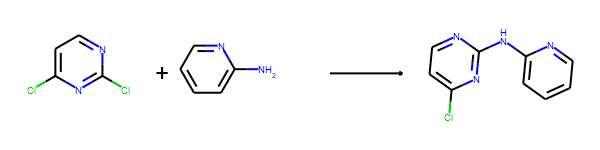

2740


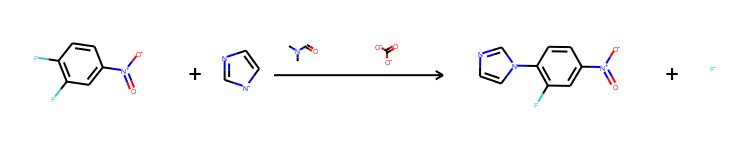

107 O=[N+]([O-])c1ccc(F)c(F)c1.c1c[n-]cn1>>O=[N+]([O-])c1ccc(F)c(-n2ccnc2)c1
Major: False
Regio: True
Chemo: False


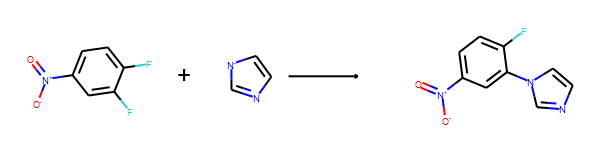

108 O=[N+]([O-])c1ccc(F)c(F)c1.c1c[n-]cn1>>O=[N+]([O-])c1ccc(-n2ccnc2)c(F)c1
Major: True
Regio: False
Chemo: False


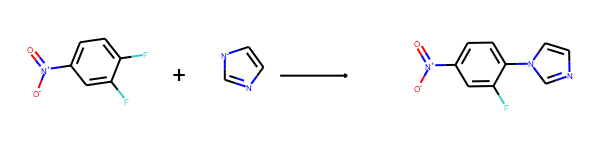

1163


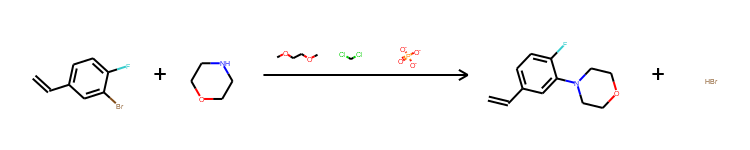

109 C1COCCN1.C=Cc1ccc(F)c(Br)c1>>C=Cc1ccc(N2CCOCC2)c(Br)c1
Major: False
Regio: True
Chemo: True


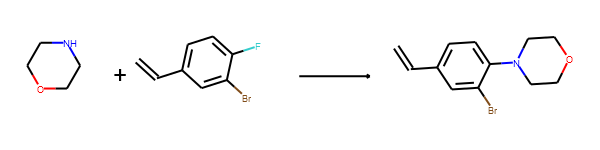

110 C1COCCN1.C=Cc1ccc(F)c(Br)c1>>C=Cc1ccc(F)c(N2CCOCC2)c1
Major: True
Regio: False
Chemo: False


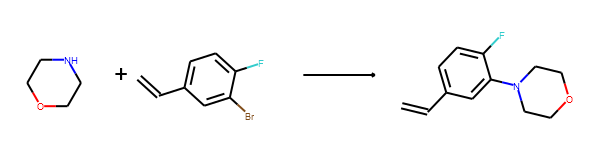

1625


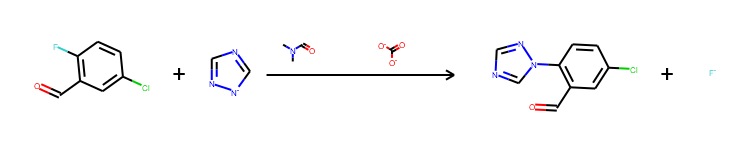

111 O=Cc1cc(Cl)ccc1F.c1nc[n-]n1>>O=Cc1cc(Cl)ccc1-n1cncn1
Major: True
Regio: False
Chemo: False


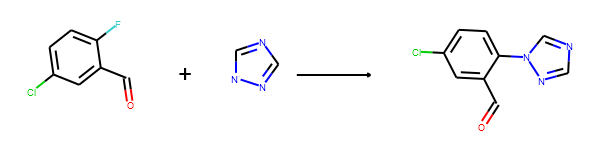

112 O=Cc1cc(Cl)ccc1F.c1nc[n-]n1>>O=Cc1cc(-n2cncn2)ccc1F
Major: False
Regio: True
Chemo: True


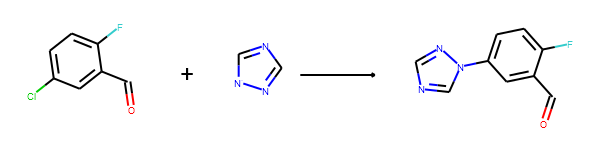

2664


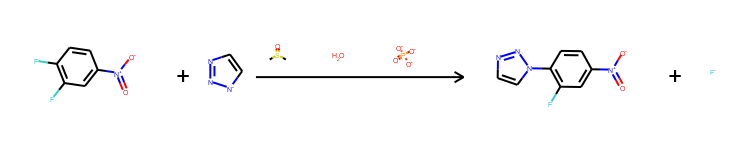

113 O=[N+]([O-])c1ccc(F)c(F)c1.c1c[n-]nn1>>O=[N+]([O-])c1ccc(F)c(-n2ccnn2)c1
Major: False
Regio: True
Chemo: False


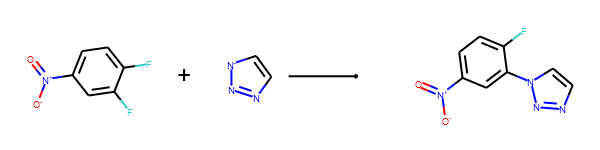

114 O=[N+]([O-])c1ccc(F)c(F)c1.c1c[n-]nn1>>O=[N+]([O-])c1ccc(-n2ccnn2)c(F)c1
Major: True
Regio: False
Chemo: False


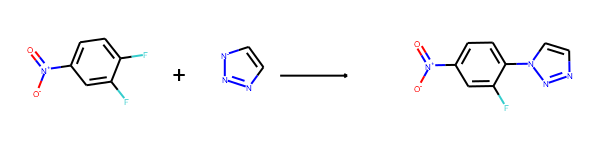

2930


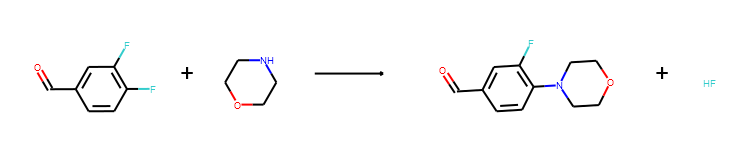

115 C1COCCN1.O=Cc1ccc(F)c(F)c1>>O=Cc1ccc(F)c(N2CCOCC2)c1
Major: False
Regio: True
Chemo: False


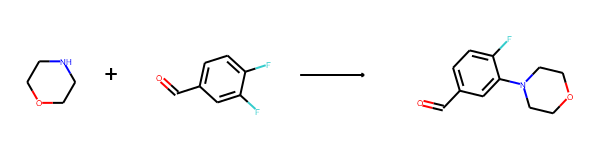

116 C1COCCN1.O=Cc1ccc(F)c(F)c1>>O=Cc1ccc(N2CCOCC2)c(F)c1
Major: True
Regio: False
Chemo: False


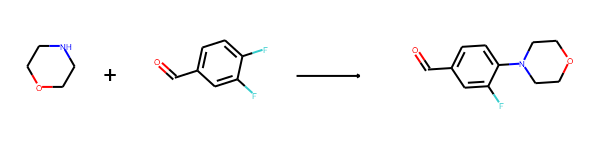

2786


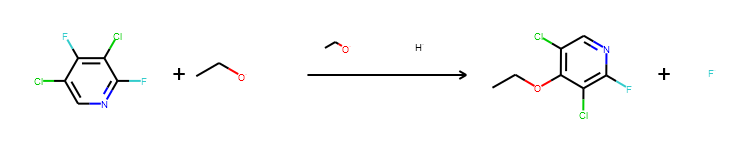

117 CC[O-].Fc1ncc(Cl)c(F)c1Cl>>CCOc1ncc(Cl)c(F)c1Cl
Major: False
Regio: True
Chemo: False


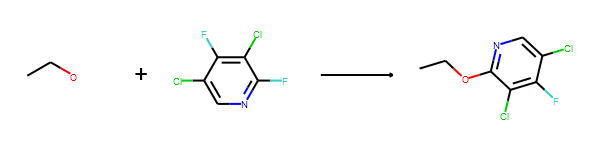

118 CC[O-].Fc1ncc(Cl)c(F)c1Cl>>CCOc1c(Cl)cnc(F)c1Cl
Major: True
Regio: False
Chemo: False


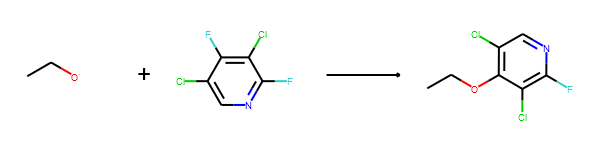

119 CC[O-].Fc1ncc(Cl)c(F)c1Cl>>CCOc1cnc(F)c(Cl)c1F
Major: False
Regio: True
Chemo: True


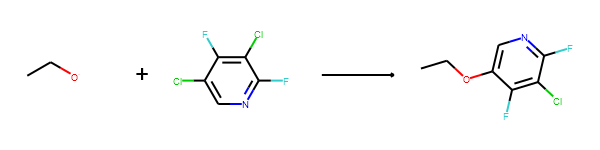

120 CC[O-].Fc1ncc(Cl)c(F)c1Cl>>CCOc1c(F)ncc(Cl)c1F
Major: False
Regio: True
Chemo: True


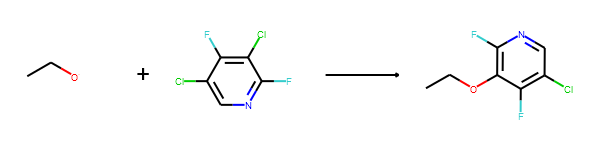

2359


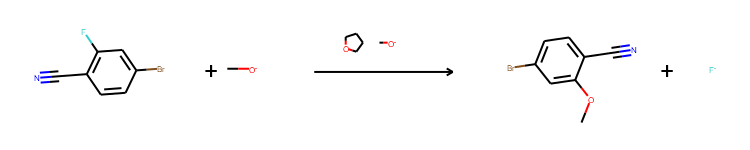

121 C[O-].N#Cc1ccc(Br)cc1F>>COc1cc(Br)ccc1C#N
Major: True
Regio: False
Chemo: False


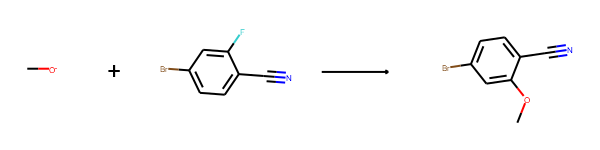

122 C[O-].N#Cc1ccc(Br)cc1F>>COc1ccc(C#N)c(F)c1
Major: False
Regio: True
Chemo: True


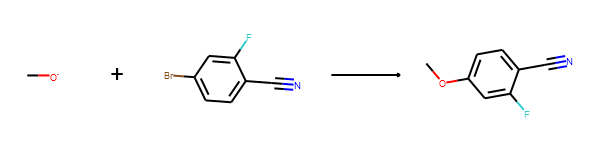

3528


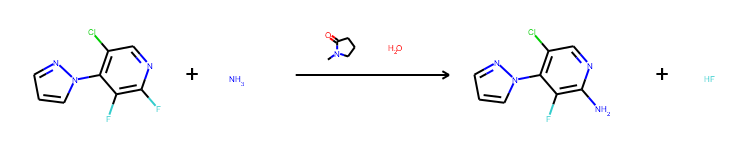

123 Fc1ncc(Cl)c(-n2cccn2)c1F.N>>Nc1ncc(Cl)c(-n2cccn2)c1F
Major: True
Regio: False
Chemo: False


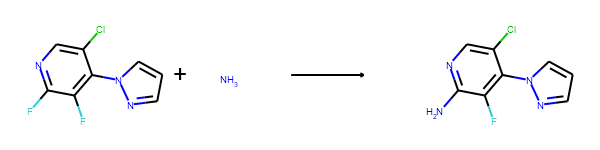

124 Fc1ncc(Cl)c(-n2cccn2)c1F.N>>Nc1c(F)ncc(Cl)c1-n1cccn1
Major: False
Regio: True
Chemo: False


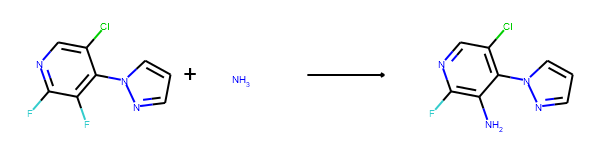

125 Fc1ncc(Cl)c(-n2cccn2)c1F.N>>Nc1cnc(F)c(F)c1-n1cccn1
Major: False
Regio: True
Chemo: True


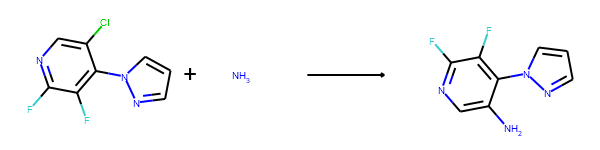

280


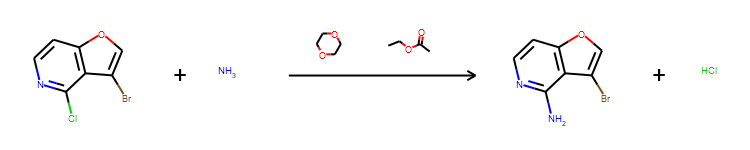

126 Clc1nccc2occ(Br)c12.N>>Nc1nccc2occ(Br)c12
Major: True
Regio: False
Chemo: False


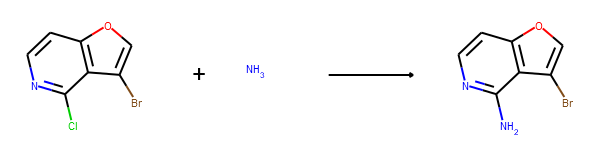

127 Clc1nccc2occ(Br)c12.N>>Nc1coc2ccnc(Cl)c12
Major: False
Regio: True
Chemo: True


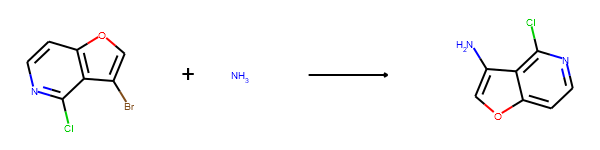

648


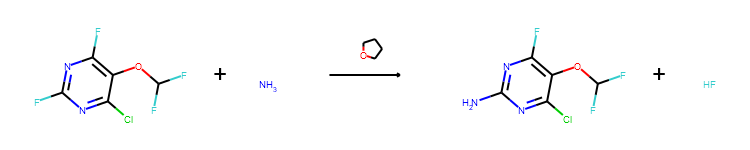

128 Fc1nc(F)c(OC(F)F)c(Cl)n1.N>>Nc1nc(F)c(OC(F)F)c(Cl)n1
Major: True
Regio: False
Chemo: False


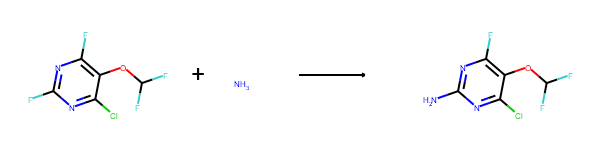

129 Fc1nc(F)c(OC(F)F)c(Cl)n1.N>>Nc1nc(F)nc(Cl)c1OC(F)F
Major: False
Regio: True
Chemo: False


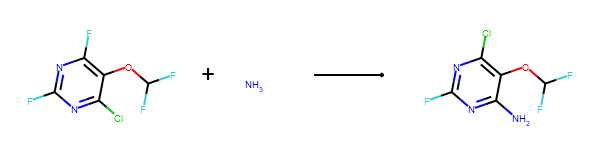

130 Fc1nc(F)c(OC(F)F)c(Cl)n1.N>>Nc1nc(F)nc(F)c1OC(F)F
Major: False
Regio: True
Chemo: True


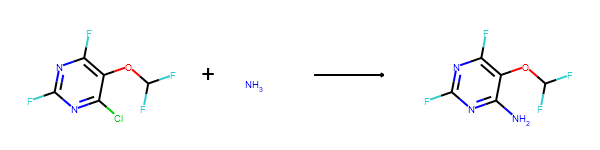

2934


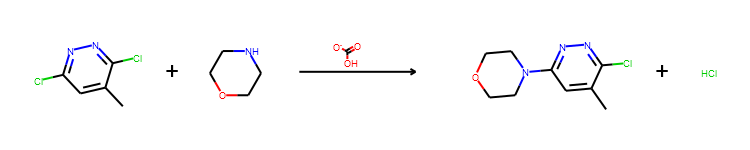

131 C1COCCN1.Cc1cc(Cl)nnc1Cl>>Cc1cc(N2CCOCC2)nnc1Cl
Major: True
Regio: False
Chemo: False


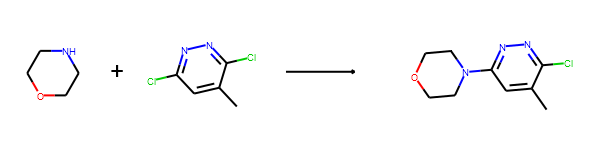

132 C1COCCN1.Cc1cc(Cl)nnc1Cl>>Cc1cc(Cl)nnc1N1CCOCC1
Major: False
Regio: True
Chemo: False


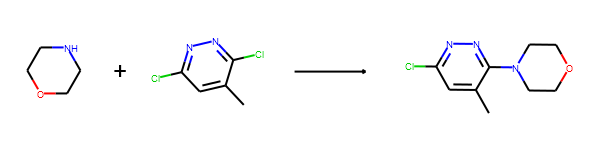

2823


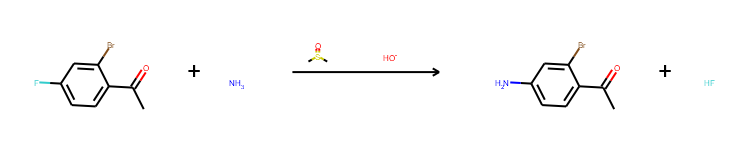

133 CC(=O)c1ccc(F)cc1Br.N>>CC(=O)c1ccc(N)cc1Br
Major: True
Regio: False
Chemo: False


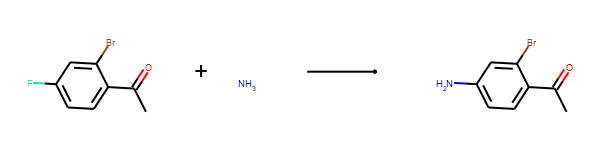

134 CC(=O)c1ccc(F)cc1Br.N>>CC(=O)c1ccc(F)cc1N
Major: False
Regio: True
Chemo: True


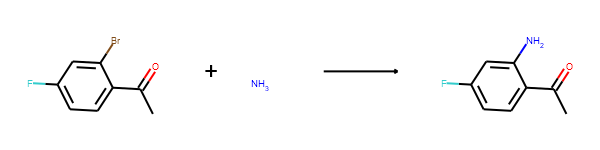

2831


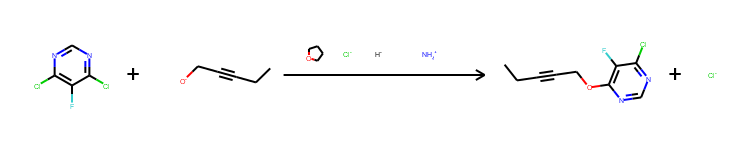

135 CCC#CC[O-].Fc1c(Cl)ncnc1Cl>>CCC#CCOc1c(Cl)ncnc1Cl
Major: False
Regio: True
Chemo: True


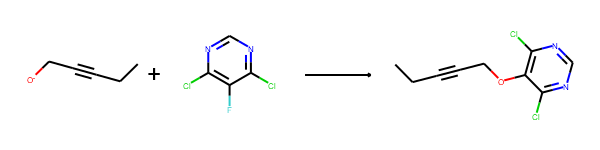

136 CCC#CC[O-].Fc1c(Cl)ncnc1Cl>>CCC#CCOc1ncnc(Cl)c1F
Major: True
Regio: False
Chemo: False


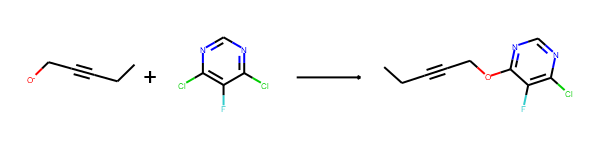

3544


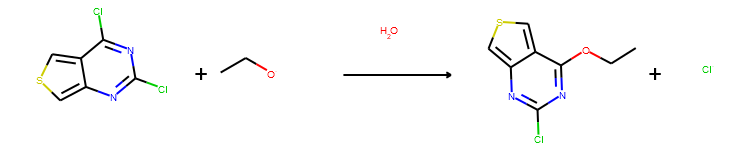

137 CC[O-].Clc1nc(Cl)c2cscc2n1>>CCOc1nc(Cl)c2cscc2n1
Major: False
Regio: True
Chemo: False


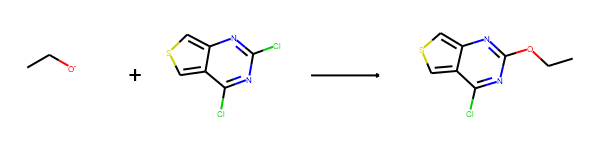

138 CC[O-].Clc1nc(Cl)c2cscc2n1>>CCOc1nc(Cl)nc2cscc12
Major: True
Regio: False
Chemo: False


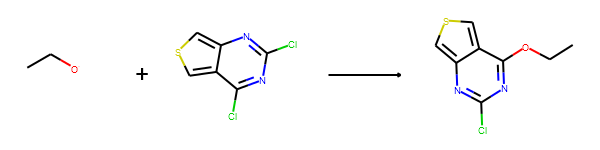

1729


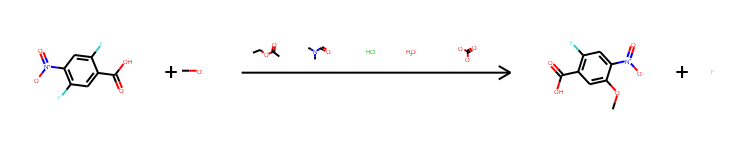

139 C[O-].O=C(O)c1cc(F)c([N+](=O)[O-])cc1F>>COc1cc(C(=O)O)c(F)cc1[N+](=O)[O-]
Major: True
Regio: False
Chemo: False


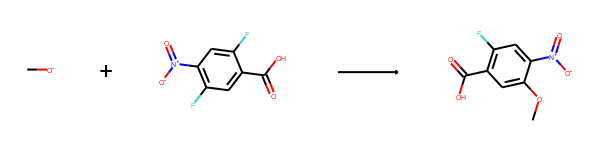

140 C[O-].O=C(O)c1cc(F)c([N+](=O)[O-])cc1F>>COc1cc([N+](=O)[O-])c(F)cc1C(=O)O
Major: False
Regio: True
Chemo: False


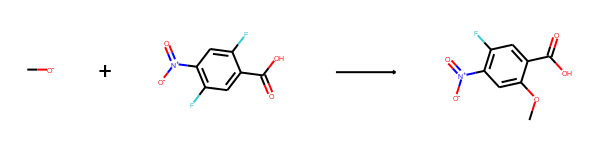

2381


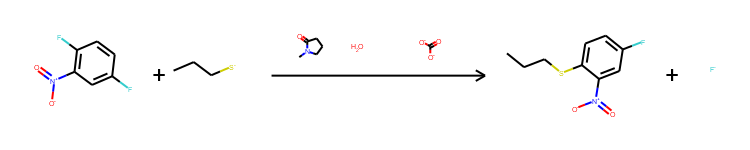

141 CCC[S-].O=[N+]([O-])c1cc(F)ccc1F>>CCCSc1ccc(F)cc1[N+](=O)[O-]
Major: True
Regio: False
Chemo: False


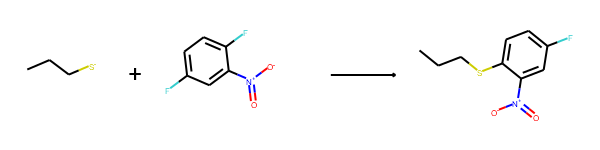

142 CCC[S-].O=[N+]([O-])c1cc(F)ccc1F>>CCCSc1ccc(F)c([N+](=O)[O-])c1
Major: False
Regio: True
Chemo: False


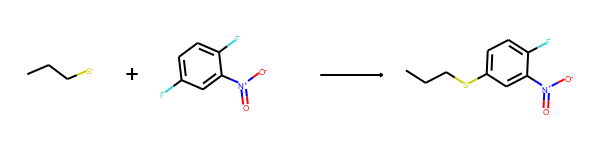

1142


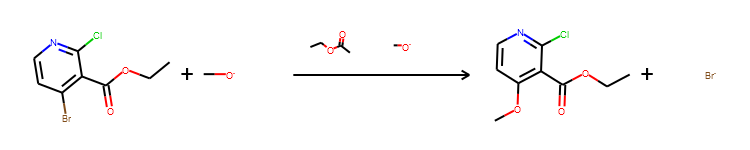

143 CCOC(=O)c1c(Br)ccnc1Cl.C[O-]>>CCOC(=O)c1c(Br)ccnc1OC
Major: False
Regio: True
Chemo: True


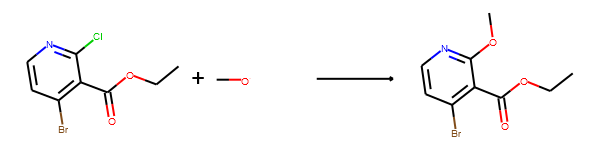

144 CCOC(=O)c1c(Br)ccnc1Cl.C[O-]>>CCOC(=O)c1c(OC)ccnc1Cl
Major: True
Regio: False
Chemo: False


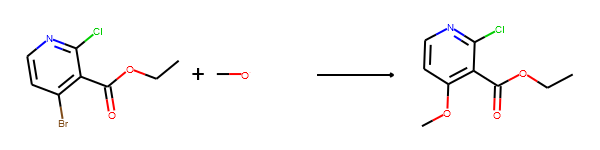

4310


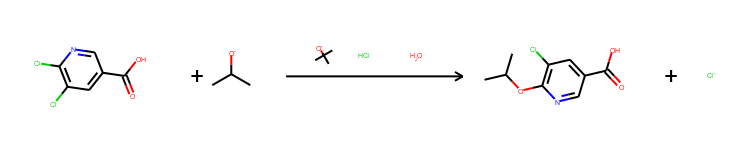

145 CC(C)[O-].O=C(O)c1cnc(Cl)c(Cl)c1>>CC(C)Oc1cc(C(=O)O)cnc1Cl
Major: False
Regio: True
Chemo: False


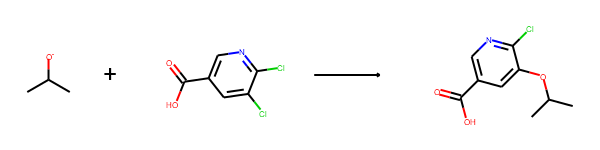

146 CC(C)[O-].O=C(O)c1cnc(Cl)c(Cl)c1>>CC(C)Oc1ncc(C(=O)O)cc1Cl
Major: True
Regio: False
Chemo: False


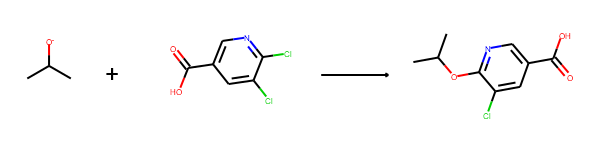

2828


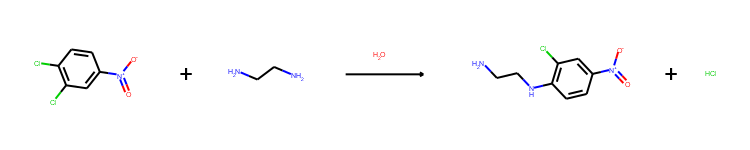

147 NCCN.O=[N+]([O-])c1ccc(Cl)c(Cl)c1>>NCCNc1cc([N+](=O)[O-])ccc1Cl
Major: False
Regio: True
Chemo: False


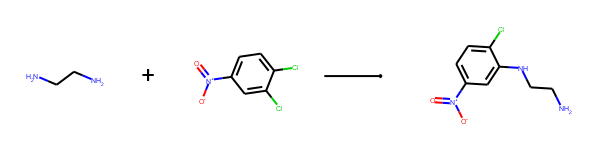

148 NCCN.O=[N+]([O-])c1ccc(Cl)c(Cl)c1>>NCCNc1ccc([N+](=O)[O-])cc1Cl
Major: True
Regio: False
Chemo: False


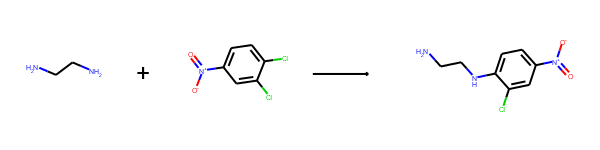

595


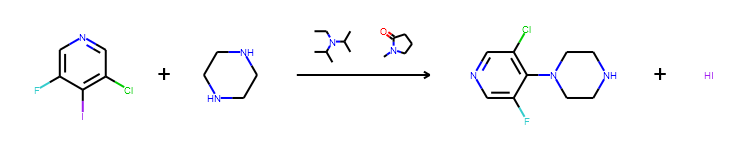

149 C1CNCCN1.Fc1cncc(Cl)c1I>>Clc1cncc(N2CCNCC2)c1I
Major: False
Regio: True
Chemo: True


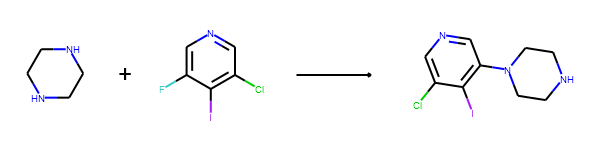

150 C1CNCCN1.Fc1cncc(Cl)c1I>>Fc1cncc(N2CCNCC2)c1I
Major: False
Regio: True
Chemo: True


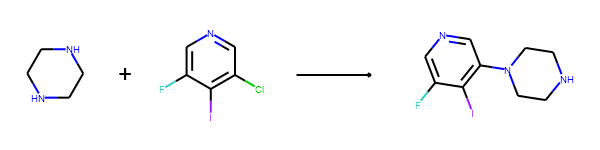

151 C1CNCCN1.Fc1cncc(Cl)c1I>>Fc1cncc(Cl)c1N1CCNCC1
Major: True
Regio: False
Chemo: False


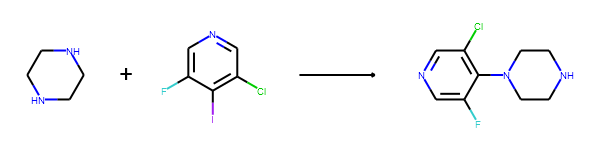

1848


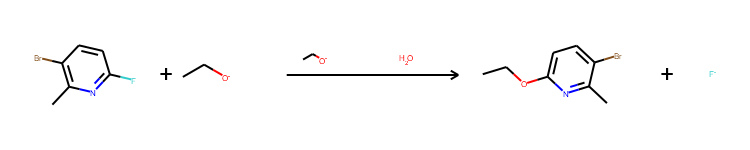

152 CC[O-].Cc1nc(F)ccc1Br>>CCOc1ccc(Br)c(C)n1
Major: True
Regio: False
Chemo: False


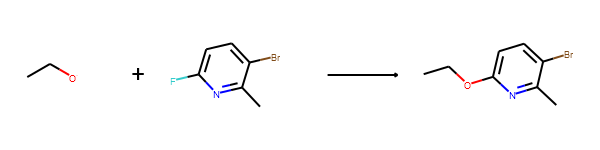

153 CC[O-].Cc1nc(F)ccc1Br>>CCOc1ccc(F)nc1C
Major: False
Regio: True
Chemo: True


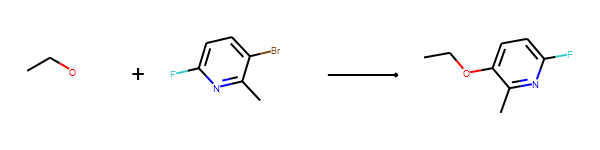

911


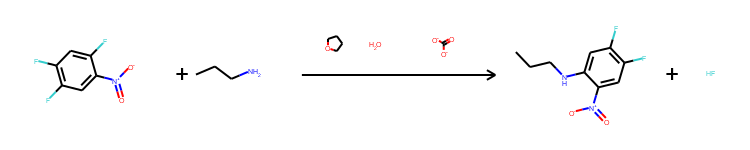

154 CCCN.O=[N+]([O-])c1cc(F)c(F)cc1F>>CCCNc1cc([N+](=O)[O-])c(F)cc1F
Major: False
Regio: True
Chemo: False


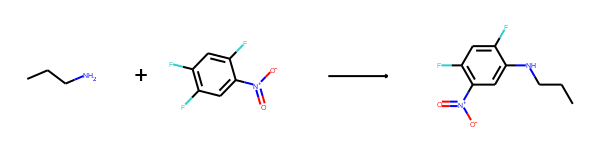

155 CCCN.O=[N+]([O-])c1cc(F)c(F)cc1F>>CCCNc1cc(F)c([N+](=O)[O-])cc1F
Major: False
Regio: True
Chemo: False


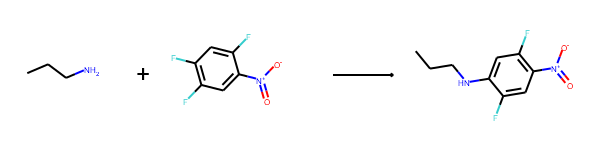

156 CCCN.O=[N+]([O-])c1cc(F)c(F)cc1F>>CCCNc1cc(F)c(F)cc1[N+](=O)[O-]
Major: True
Regio: False
Chemo: False


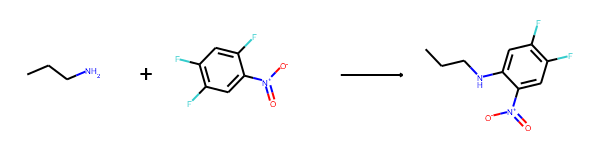

2903


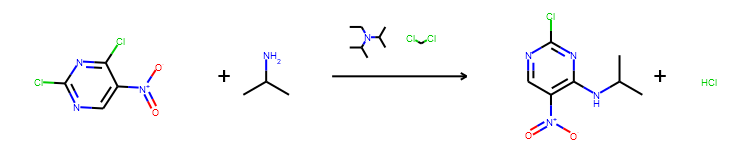

157 CC(C)N.O=[N+]([O-])c1cnc(Cl)nc1Cl>>CC(C)Nc1ncc([N+](=O)[O-])c(Cl)n1
Major: False
Regio: True
Chemo: False


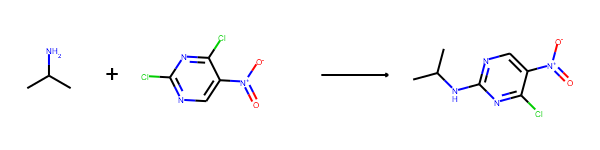

158 CC(C)N.O=[N+]([O-])c1cnc(Cl)nc1Cl>>CC(C)Nc1nc(Cl)ncc1[N+](=O)[O-]
Major: True
Regio: False
Chemo: False


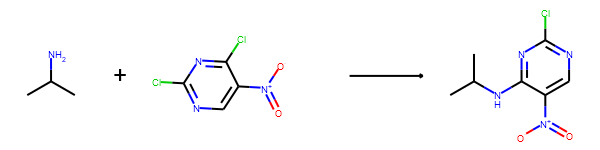

3954


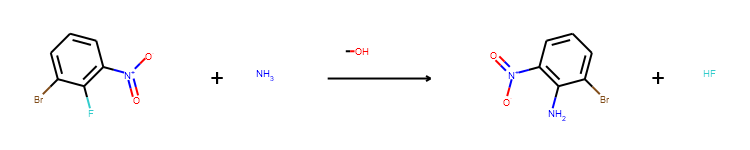

159 N.O=[N+]([O-])c1cccc(Br)c1F>>Nc1c(Br)cccc1[N+](=O)[O-]
Major: True
Regio: False
Chemo: False


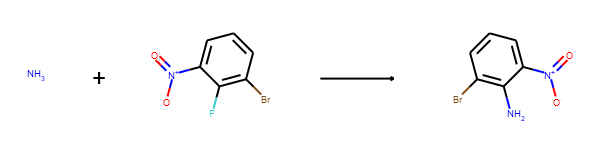

160 N.O=[N+]([O-])c1cccc(Br)c1F>>Nc1cccc([N+](=O)[O-])c1F
Major: False
Regio: True
Chemo: True


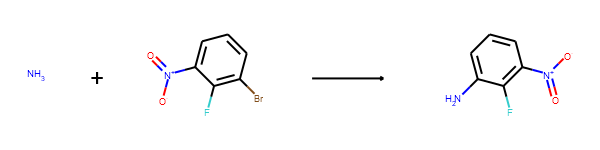

575


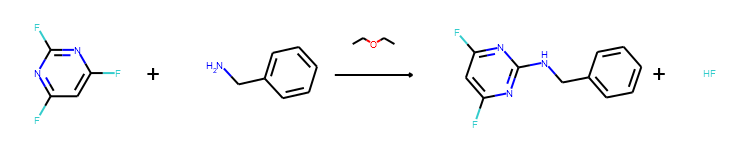

161 Fc1cc(F)nc(F)n1.NCc1ccccc1>>Fc1cc(NCc2ccccc2)nc(F)n1
Major: False
Regio: True
Chemo: False


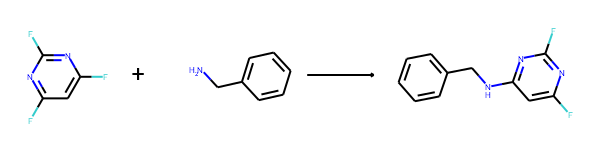

162 Fc1cc(F)nc(F)n1.NCc1ccccc1>>Fc1cc(F)nc(NCc2ccccc2)n1
Major: True
Regio: False
Chemo: False


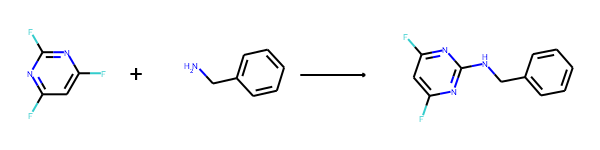

3540


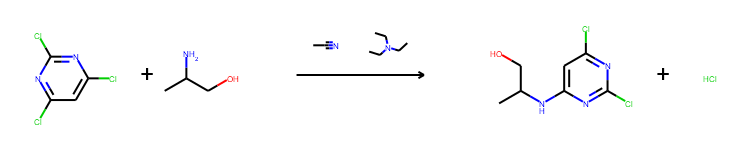

163 CC(N)CO.Clc1cc(Cl)nc(Cl)n1>>CC(CO)Nc1cc(Cl)nc(Cl)n1
Major: True
Regio: False
Chemo: False


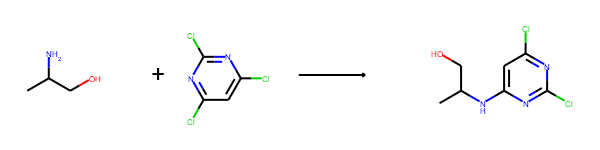

164 CC(N)CO.Clc1cc(Cl)nc(Cl)n1>>CC(CO)Nc1nc(Cl)cc(Cl)n1
Major: False
Regio: True
Chemo: False


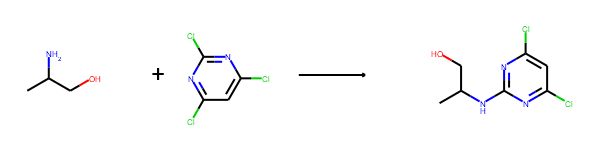

1191


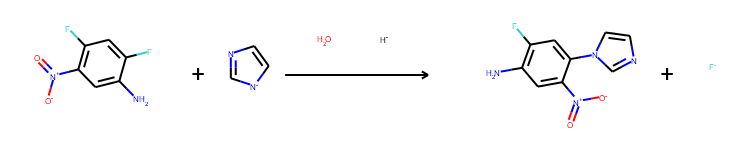

165 Nc1cc([N+](=O)[O-])c(F)cc1F.c1c[n-]cn1>>Nc1cc([N+](=O)[O-])c(-n2ccnc2)cc1F
Major: True
Regio: False
Chemo: False


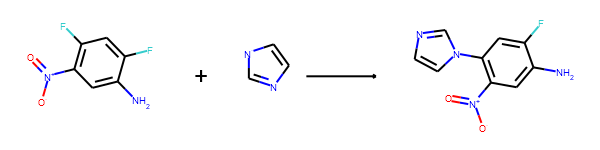

166 Nc1cc([N+](=O)[O-])c(F)cc1F.c1c[n-]cn1>>Nc1cc([N+](=O)[O-])c(F)cc1-n1ccnc1
Major: False
Regio: True
Chemo: False


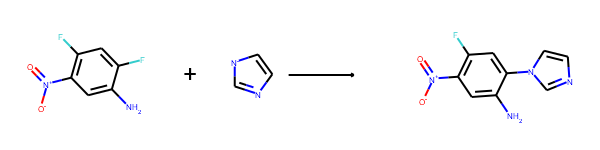

2425


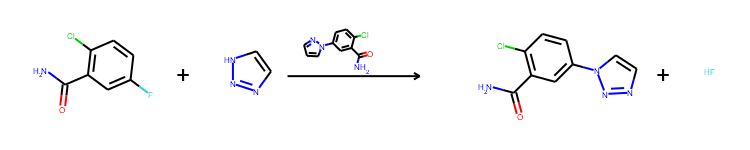

167 NC(=O)c1cc(F)ccc1Cl.c1c[nH]nn1>>NC(=O)c1cc(-n2ccnn2)ccc1Cl
Major: True
Regio: False
Chemo: False


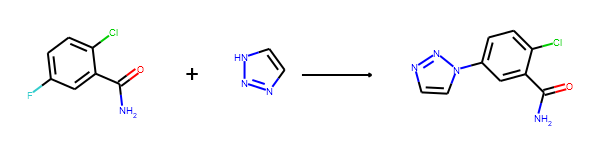

168 NC(=O)c1cc(F)ccc1Cl.c1c[nH]nn1>>NC(=O)c1cc(F)ccc1-n1ccnn1
Major: False
Regio: True
Chemo: True


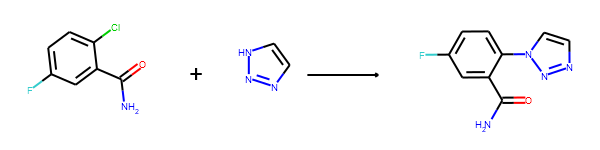

4399


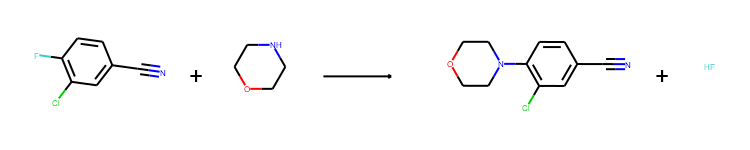

169 C1COCCN1.N#Cc1ccc(F)c(Cl)c1>>N#Cc1ccc(N2CCOCC2)c(Cl)c1
Major: True
Regio: False
Chemo: False


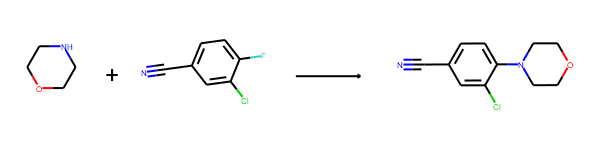

170 C1COCCN1.N#Cc1ccc(F)c(Cl)c1>>N#Cc1ccc(F)c(N2CCOCC2)c1
Major: False
Regio: True
Chemo: True


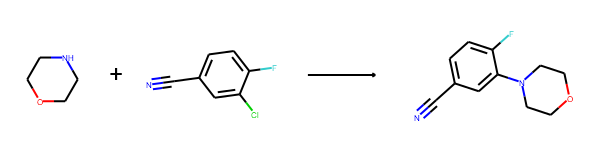

455


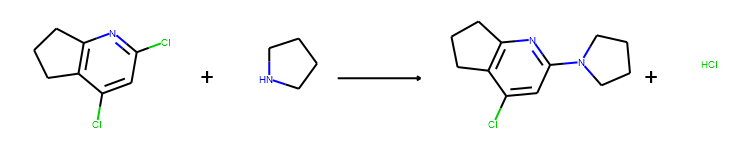

171 C1CCNC1.Clc1cc(Cl)c2c(n1)CCC2>>Clc1cc(N2CCCC2)c2c(n1)CCC2
Major: False
Regio: True
Chemo: False


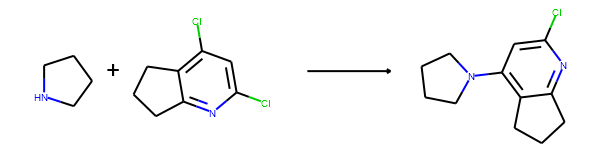

172 C1CCNC1.Clc1cc(Cl)c2c(n1)CCC2>>Clc1cc(N2CCCC2)nc2c1CCC2
Major: True
Regio: False
Chemo: False


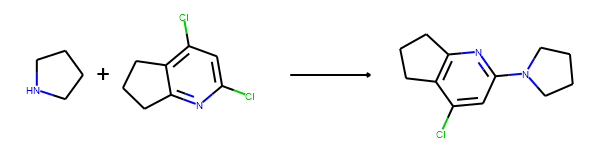

3705


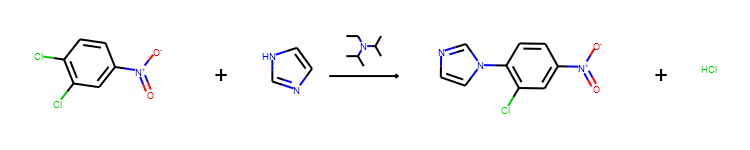

173 O=[N+]([O-])c1ccc(Cl)c(Cl)c1.c1c[nH]cn1>>O=[N+]([O-])c1ccc(Cl)c(-n2ccnc2)c1
Major: False
Regio: True
Chemo: False


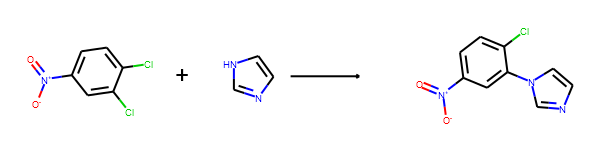

174 O=[N+]([O-])c1ccc(Cl)c(Cl)c1.c1c[nH]cn1>>O=[N+]([O-])c1ccc(-n2ccnc2)c(Cl)c1
Major: True
Regio: False
Chemo: False


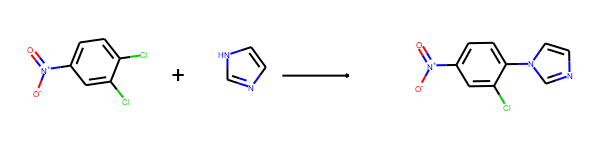

1702


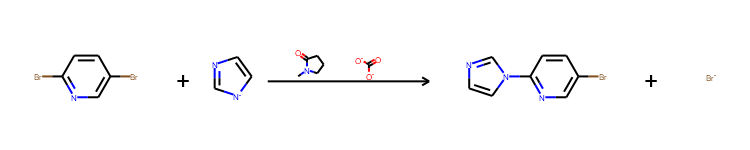

175 Brc1ccc(Br)nc1.c1c[n-]cn1>>Brc1ccc(-n2ccnc2)cn1
Major: False
Regio: True
Chemo: False


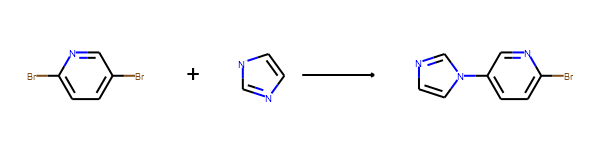

176 Brc1ccc(Br)nc1.c1c[n-]cn1>>Brc1ccc(-n2ccnc2)nc1
Major: True
Regio: False
Chemo: False


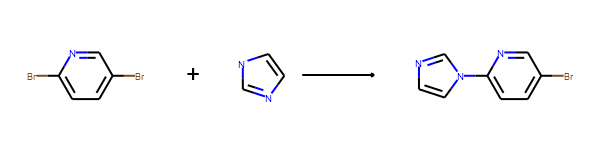

3292


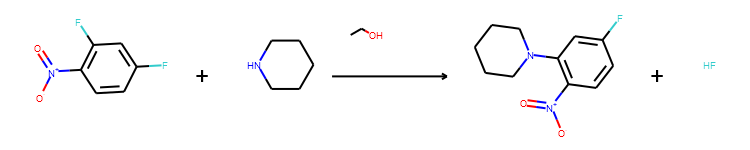

177 C1CCNCC1.O=[N+]([O-])c1ccc(F)cc1F>>O=[N+]([O-])c1ccc(F)cc1N1CCCCC1
Major: True
Regio: False
Chemo: False


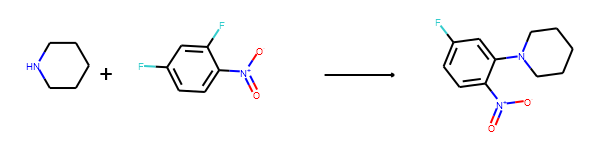

178 C1CCNCC1.O=[N+]([O-])c1ccc(F)cc1F>>O=[N+]([O-])c1ccc(N2CCCCC2)cc1F
Major: False
Regio: True
Chemo: False


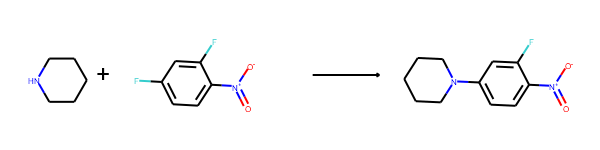

1584


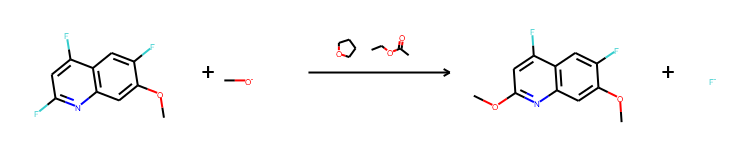

179 COc1cc2nc(F)cc(F)c2cc1F.C[O-]>>COc1cc2nc(F)cc(F)c2cc1OC
Major: False
Regio: True
Chemo: False


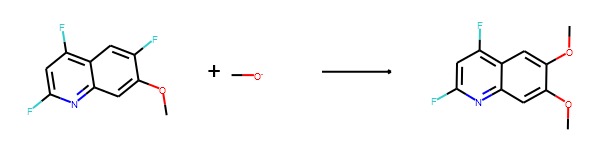

180 COc1cc2nc(F)cc(F)c2cc1F.C[O-]>>COc1cc2nc(F)cc(OC)c2cc1F
Major: False
Regio: True
Chemo: False


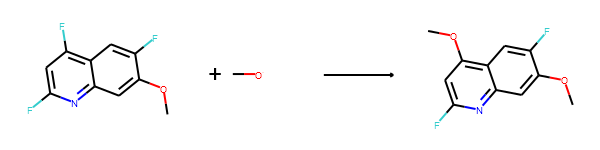

181 COc1cc2nc(F)cc(F)c2cc1F.C[O-]>>COc1cc(F)c2cc(F)c(OC)cc2n1
Major: True
Regio: False
Chemo: False


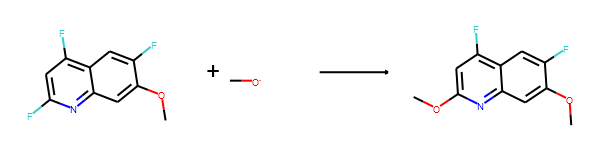

3887


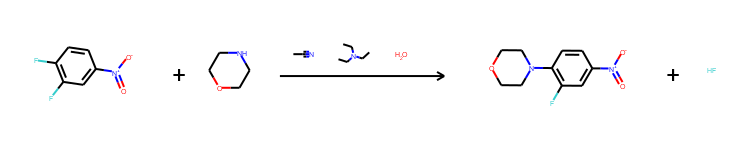

182 C1COCCN1.O=[N+]([O-])c1ccc(F)c(F)c1>>O=[N+]([O-])c1ccc(F)c(N2CCOCC2)c1
Major: False
Regio: True
Chemo: False


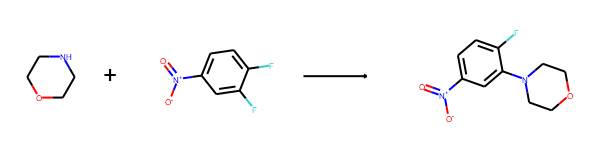

183 C1COCCN1.O=[N+]([O-])c1ccc(F)c(F)c1>>O=[N+]([O-])c1ccc(N2CCOCC2)c(F)c1
Major: True
Regio: False
Chemo: False


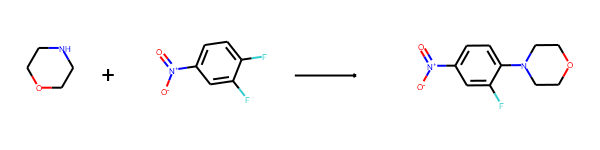

3370


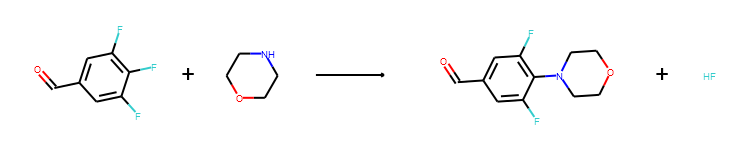

184 C1COCCN1.O=Cc1cc(F)c(F)c(F)c1>>O=Cc1cc(F)c(F)c(N2CCOCC2)c1
Major: False
Regio: True
Chemo: False


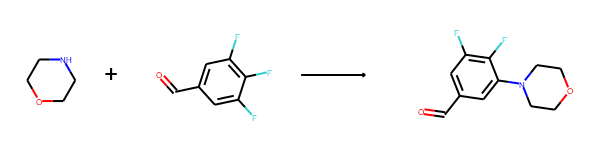

185 C1COCCN1.O=Cc1cc(F)c(F)c(F)c1>>O=Cc1cc(F)c(N2CCOCC2)c(F)c1
Major: True
Regio: False
Chemo: False


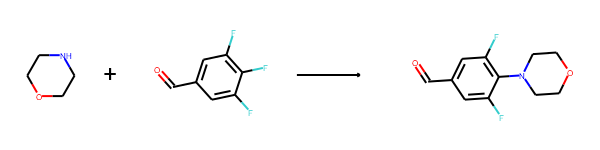

674


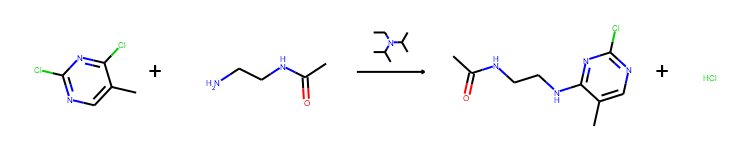

186 CC(=O)NCCN.Cc1cnc(Cl)nc1Cl>>CC(=O)NCCNc1ncc(C)c(Cl)n1
Major: False
Regio: True
Chemo: False


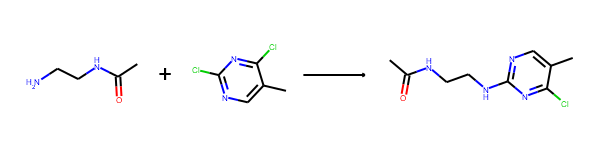

187 CC(=O)NCCN.Cc1cnc(Cl)nc1Cl>>CC(=O)NCCNc1nc(Cl)ncc1C
Major: True
Regio: False
Chemo: False


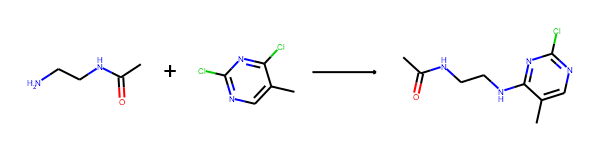

1159


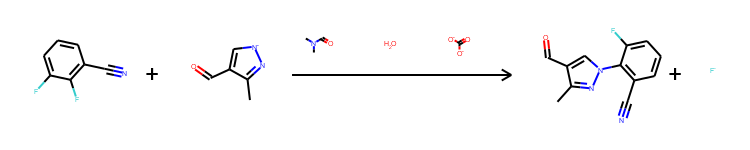

188 Cc1n[n-]cc1C=O.N#Cc1cccc(F)c1F>>Cc1nn(-c2c(F)cccc2C#N)cc1C=O
Major: True
Regio: False
Chemo: False


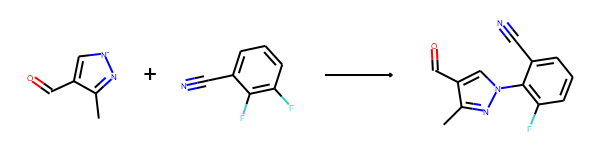

189 Cc1n[n-]cc1C=O.N#Cc1cccc(F)c1F>>Cc1nn(-c2cccc(C#N)c2F)cc1C=O
Major: False
Regio: True
Chemo: False


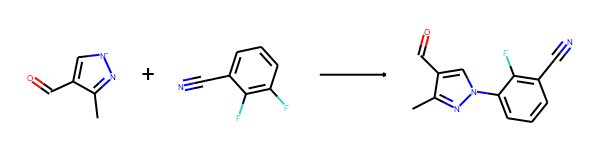

3471


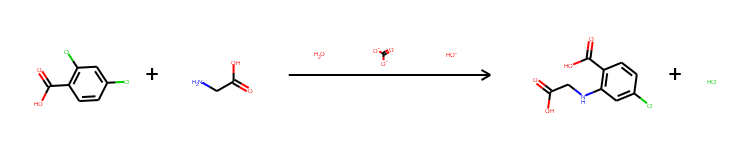

190 NCC(=O)O.O=C(O)c1ccc(Cl)cc1Cl>>O=C(O)CNc1cc(Cl)ccc1C(=O)O
Major: True
Regio: False
Chemo: False


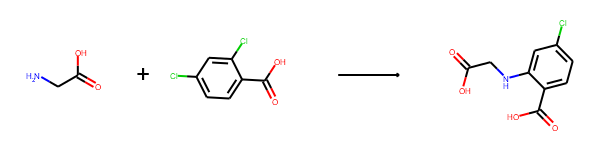

191 NCC(=O)O.O=C(O)c1ccc(Cl)cc1Cl>>O=C(O)CNc1ccc(C(=O)O)c(Cl)c1
Major: False
Regio: True
Chemo: False


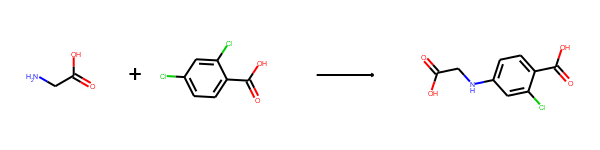

2421


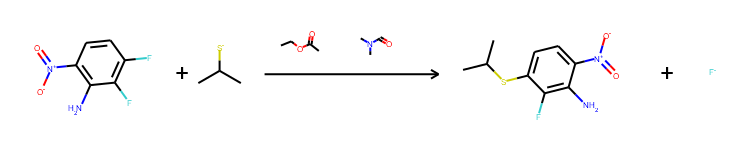

192 CC(C)[S-].Nc1c([N+](=O)[O-])ccc(F)c1F>>CC(C)Sc1ccc([N+](=O)[O-])c(N)c1F
Major: True
Regio: False
Chemo: False


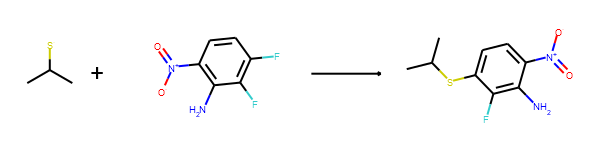

193 CC(C)[S-].Nc1c([N+](=O)[O-])ccc(F)c1F>>CC(C)Sc1c(F)ccc([N+](=O)[O-])c1N
Major: False
Regio: True
Chemo: False


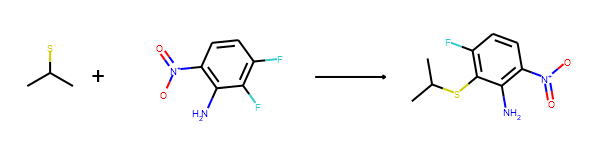

4318


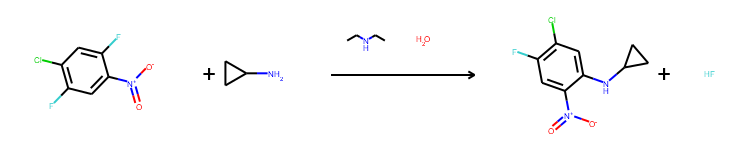

194 NC1CC1.O=[N+]([O-])c1cc(F)c(Cl)cc1F>>O=[N+]([O-])c1cc(NC2CC2)c(Cl)cc1F
Major: False
Regio: True
Chemo: False


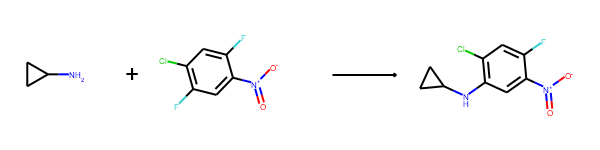

195 NC1CC1.O=[N+]([O-])c1cc(F)c(Cl)cc1F>>O=[N+]([O-])c1cc(F)c(Cl)cc1NC1CC1
Major: True
Regio: False
Chemo: False


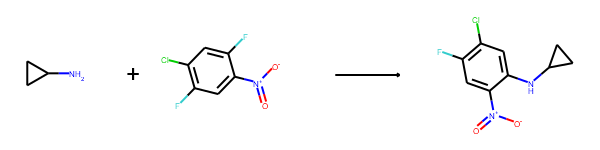

196 NC1CC1.O=[N+]([O-])c1cc(F)c(Cl)cc1F>>O=[N+]([O-])c1cc(F)c(NC2CC2)cc1F
Major: False
Regio: True
Chemo: True


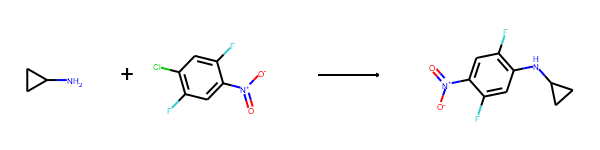

2927


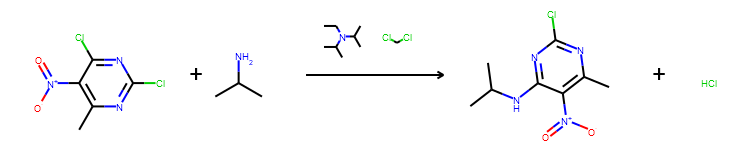

197 CC(C)N.Cc1nc(Cl)nc(Cl)c1[N+](=O)[O-]>>Cc1nc(Cl)nc(NC(C)C)c1[N+](=O)[O-]
Major: True
Regio: False
Chemo: False


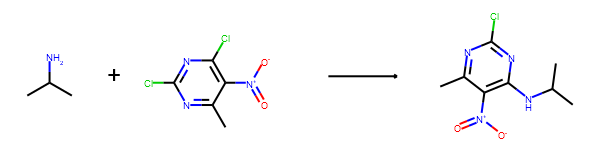

198 CC(C)N.Cc1nc(Cl)nc(Cl)c1[N+](=O)[O-]>>Cc1nc(NC(C)C)nc(Cl)c1[N+](=O)[O-]
Major: False
Regio: True
Chemo: False


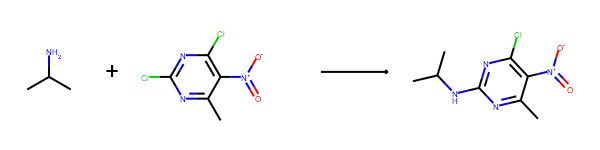

4110


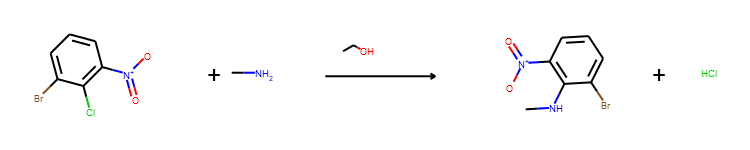

199 CN.O=[N+]([O-])c1cccc(Br)c1Cl>>CNc1c(Br)cccc1[N+](=O)[O-]
Major: True
Regio: False
Chemo: False


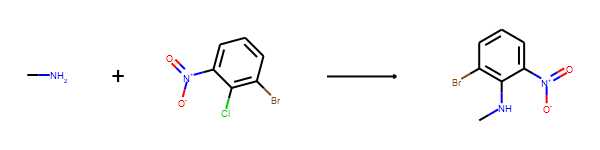

200 CN.O=[N+]([O-])c1cccc(Br)c1Cl>>CNc1cccc([N+](=O)[O-])c1Cl
Major: False
Regio: True
Chemo: True


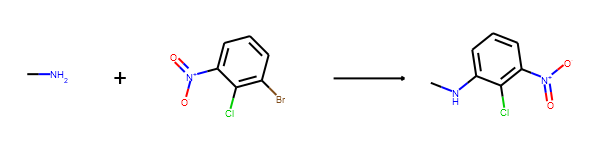

2028


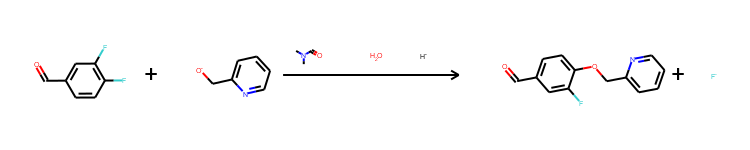

201 O=Cc1ccc(F)c(F)c1.[O-]Cc1ccccn1>>O=Cc1ccc(F)c(OCc2ccccn2)c1
Major: False
Regio: True
Chemo: False


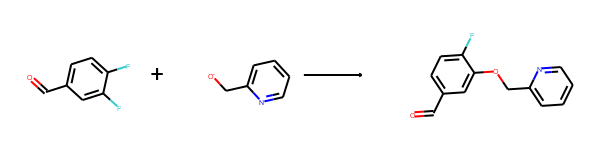

202 O=Cc1ccc(F)c(F)c1.[O-]Cc1ccccn1>>O=Cc1ccc(OCc2ccccn2)c(F)c1
Major: True
Regio: False
Chemo: False


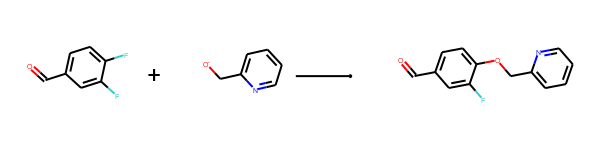

252


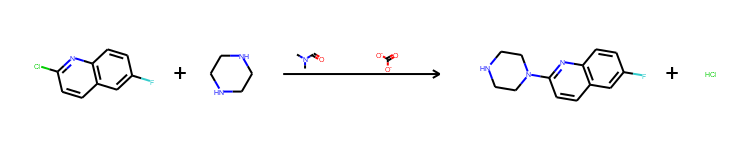

203 C1CNCCN1.Fc1ccc2nc(Cl)ccc2c1>>Clc1ccc2cc(N3CCNCC3)ccc2n1
Major: False
Regio: True
Chemo: True


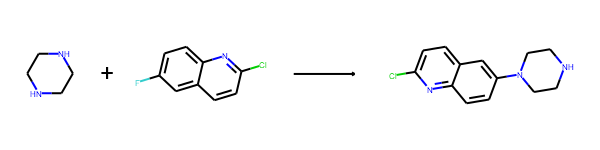

204 C1CNCCN1.Fc1ccc2nc(Cl)ccc2c1>>Fc1ccc2nc(N3CCNCC3)ccc2c1
Major: True
Regio: False
Chemo: False


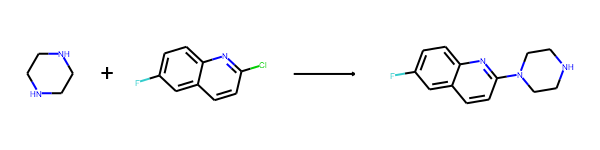

3213


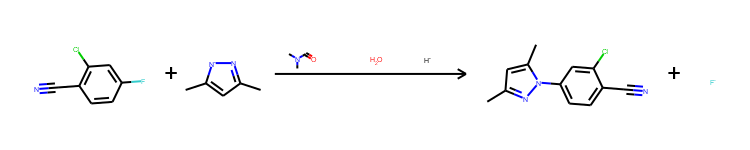

205 Cc1cc(C)[n-]n1.N#Cc1ccc(F)cc1Cl>>Cc1cc(C)n(-c2ccc(C#N)c(Cl)c2)n1
Major: True
Regio: False
Chemo: False


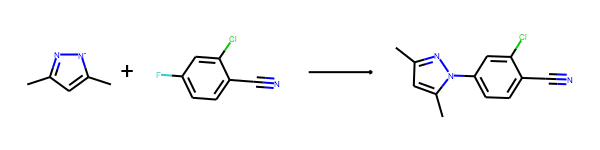

206 Cc1cc(C)[n-]n1.N#Cc1ccc(F)cc1Cl>>Cc1cc(C)n(-c2cc(F)ccc2C#N)n1
Major: False
Regio: True
Chemo: True


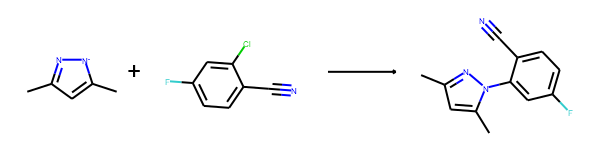

689


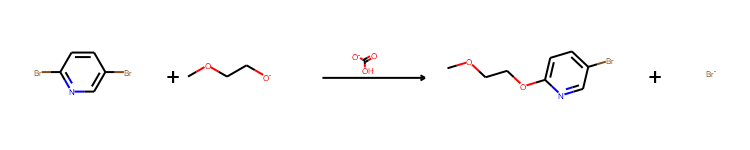

207 Brc1ccc(Br)nc1.COCC[O-]>>COCCOc1ccc(Br)nc1
Major: False
Regio: True
Chemo: False


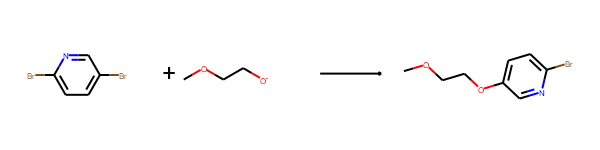

208 Brc1ccc(Br)nc1.COCC[O-]>>COCCOc1ccc(Br)cn1
Major: True
Regio: False
Chemo: False


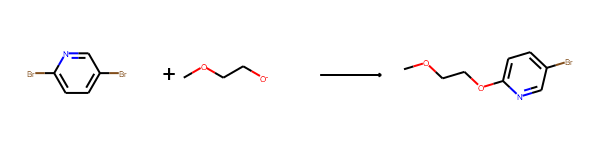

In [39]:
for i in top_reactions:
    print(i)
    reactions = reaction_df[reaction_df["reaction_id"] == i]
    orig_reaction = iso_df.loc[i]["rsmp"].reaction
    display(orig_reaction)
    for j, row in reactions.iterrows():
        print(j, row["reaction_smiles"])
        reaction = AllChem.ReactionFromSmarts(row["reaction_smiles"], useSmiles=True)
        print("Major:", row["major"])
        print("Regio:", row["regio"])
        print("Chemo:", row["chemo"])
        display(reaction)

In [ ]:
for i, row in reaction_df[reaction_df["reaction_id"].isin(top_reactions)].iterrows():a
    
    print(row["reaction_id"])
    
    display(reaction)